In [ ]:
import typing

import pandas as pd

import config
import src
import requests
import tqdm
import json
import numpy as np
import src

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time
import matplotlib.pyplot as plt



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\sstolwi\Git

In [2]:
CFG = config.Config()

In [3]:
dataset: pd.DataFrame = pd.read_csv('data/publicsphere/full_data.csv')
dataset

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,dislikeCount_video,likeCount_video,date_difference,commentCount_video,replyCount_comment,topic,subscribers,HATELIST_FOCUSED_DUMMY,Time_comment_year,Time_video_year
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2017,2017.0
1,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1,6,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282,1,2,1,...,195.0,3817.0,743.0,1748.0,NaN,economy,3630000.0,0,2019,2019.0
2,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1,6,1110578710648890000,372,2,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
3,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1,6,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,2018.0
4,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,8/19/2021 14:50:13,8/19/2021 14:54:28,62.194.51.29,1,6,1152219467579100000,10000695,0,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
3858,8/19/2021 15:10:27,8/19/2021 15:12:21,62.194.51.29,1,6,1085362296472430000,10007008,1,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
3859,10/6/2021 16:08:39,10/6/2021 16:10:42,213.127.113.113,1,6,UghFY3QJ6nmT_ngCoAEC.7-H0Z7--wxd8goqpaPs-bl,20000102,0,3,1,...,2820.0,12475.0,3803.0,4785.0,NaN,east,6740000.0,0,2018,2010.0
3860,10/15/2021 18:30:04,10/15/2021 18:35:40,213.127.109.191,1,6,UgyWabsmmnq3zam4DgZ4AaABAg,20000418,2,3,1,...,118.0,31761.0,1531.0,2206.0,0.0,east,6800000.0,0,2018,2015.0


In [4]:
#load train/test data
trainset: pd.DataFrame = pd.read_csv('data/publicsphere/train.csv')
testset: pd.DataFrame = pd.read_csv('data/publicsphere/test.csv')

In [5]:
trainset.head()

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,dislikeCount_video,likeCount_video,date_difference,commentCount_video,replyCount_comment,topic,subscribers,HATELIST_FOCUSED_DUMMY,Time_comment_year,Time_video_year
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2017,2017.0
1,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1,6,1110578710648890000,372,2,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
2,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,2018.0
3,11/30/2021 17:24:18,11/30/2021 17:27:16,213.127.109.191,1,6,Ugw2eTvkZLfH9MDVg1R4AaABAg,1214,1,2,1,...,662.0,9472.0,743.0,2912.0,0.0,economy,3630000.0,1,2019,2018.0
4,6/18/2021 17:59:54,6/18/2021 18:01:59,213.127.126.118,1,6,Ugi7W7rSRtQSQngCoAEC.8SSDZOcrB8y8SSIYSKC0FI,1963,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2017,2017.0


In [5]:
#add train/test split variable to the dataset:
dataset.loc[dataset['Mark_ID'].isin(trainset['Mark_ID']), 'split'] = 'train'
dataset.loc[dataset['Mark_ID'].isin(testset['Mark_ID']), 'split'] = 'test'

In [15]:
dataset['split'].value_counts()

split
train    3089
test      773
Name: count, dtype: int64

In [4]:
#set option variables:

#set options to low temperature (0,1):
options_low_str = """
seed: 42
temperature: 0.1
"""

options_low = yaml.safe_load(options_low_str)

MODELsmall: str = 'llama3.1:8b-instruct-q6_K' # options: 'gemma:7b-instruct-q6_K', 'gemma2:27b-instruct-q6_K', 'llama3.1:8b-instruct-q6_K', 'llama3.1:70b-instruct-q6_K', 'mistral:7b-instruct-v0.3-q6_K', 'mistral-large:123b-instruct-2407-q6_K', 'mixtral:8x7b-instruct-v0.1-q6_K', 'mixtral:8x22b-instruct-v0.1-q6_K', 'phi3:14b-medium-128k-instruct-q6_K' or 'qwen2:72b-instruct-q6_K'
MODELlarge: str = 'llama3.1:70b-instruct-q6_K' # options: 'gemma:7b-instruct-q6_K', 'gemma2:27b-instruct-q6_K', 'llama3.1:8b-instruct-q6_K', 'llama3.1:70b-instruct-q6_K', 'mistral:7b-instruct-v0.3-q6_K', 'mistral-large:123b-instruct-2407-q6_K', 'mixtral:8x7b-instruct-v0.1-q6_K', 'mixtral:8x22b-instruct-v0.1-q6_K', 'phi3:14b-medium-128k-instruct-q6_K' or 'qwen2:72b-instruct-q6_K'
MODELgpt4o = "nf-gpt-4o-2024-08-06" # in principe is er nu van elk model een nf (no filter) en een normale versie beschikbaar, de no filter versies zijn alleen voor onderzoekers beschikbaar voor analyze van content die niet door de filter heen zou komen.
MODELgpt4T = "nf-gpt-4-turbo" # Can be gpt-35-turbo, gpt-4-turbo, gpt-4 or Meta-Llama-3-8B-Instruct.

options_zero_str = """
seed: 42
temperature: 0
"""
options_zero = yaml.safe_load(options_zero_str)

temperature_0 : int = 0
SEED: int = 42
MAX10: int = 10
TOPP1: int = 1


options_large_str = """
seed: 42
temperature: 0
num_predict: 2000
"""
options_large = yaml.safe_load(options_large_str)

#load environment variables:
api_key = os.environ.get('sjoerd_key')

#setttings:
api_endpoint = "https://ai-research-proxy.azurewebsites.net/chat/completions"
####### API REQUEST FORMATTING ######
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + api_key
}
 

In [6]:
#load the dataset:
#note this dataset already contains the output, do not try to overwrite it.
dataset_w_pred_anon = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')

In [ ]:
#add train/test split variable to the dataset:
dataset_w_pred_anon.loc[dataset_w_pred_anon['Mark_ID'].isin(trainset['Mark_ID']), 'split'] = 'train'
dataset_w_pred_anon.loc[dataset_w_pred_anon['Mark_ID'].isin(testset['Mark_ID']), 'split'] = 'test'

In [ ]:
pubspherepromptsrun1 = ['incivility_namecalling_edit']   #repeat for all prompts
predictions1: typing.Dict[str, np.ndarray] = {
    label: (
        src.PromptClassify
        .from_json(path)
        (dataset["commentText"], model=MODELlarge, options=options_low)
    )
    for label, path in CFG.prompt_classify_files.items() if label in pubspherepromptsrun1
}

In [42]:
#join to the dataset:   
for _, preds in predictions1.items():
    print(preds.value_counts())
    print("-" * 42)
    dataset_w_pred_2 = dataset_w_pred_2.join(preds)
    dataset_w_pred_anon = dataset_w_pred_anon.join(preds)

incivility_namecalling
No     2670
Yes    1189
Name: count, dtype: int64
------------------------------------------
incivility_namecalling_edit
No     2486
Yes    1371
Name: count, dtype: int64
------------------------------------------


In [57]:
#make dummy variables:
dataset_w_pred_anon.loc[:, 'incivility_allcaps_dum'] = dataset_w_pred_anon.loc[:, 'incivility_allcaps'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_attackreputation_dum'] = dataset_w_pred_anon.loc[:, 'incivility_attackreputation'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_question_intelligence_dum'] = dataset_w_pred_anon.loc[:, 'incivility_question_intelligence'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_sarcasm_dum'] = dataset_w_pred_anon.loc[:, 'incivility_sarcasm'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_namecalling_dum'] = dataset_w_pred_anon.loc[:, 'incivility_namecalling'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_vulgarity_dum'] = dataset_w_pred_anon.loc[:, 'incivility_vulgarity'].map({"Yes": 1, "No":0}).fillna(0).astype(int)


dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_dum'] = dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_low'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_external_evidence_dum'] = dataset_w_pred_anon.loc[:, 'rationality_external_evidence_low'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_topic_relevance_dum'] = dataset_w_pred_anon.loc[:, 'rationality_topic_relevance_low'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_background_info_low_dum'] = dataset_w_pred_anon.loc[:, 'rationality_background_info_low'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_reasoning_dum'] = dataset_w_pred_anon.loc[:, 'rationality_reasoning_low'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'intolerance_discrimination_dum'] = dataset_w_pred_anon.loc[:, 'intolerance_discrimination'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'intolerance_rights_dum'] = dataset_w_pred_anon.loc[:, 'intolerance_rights'].map({"Yes": 1, "No":0}).fillna(0).astype(int)   
dataset_w_pred_anon.loc[:, 'intolerance_violence_dum'] = dataset_w_pred_anon.loc[:, 'intolerance_violence'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_namecalling_dum'] = dataset_w_pred_anon.loc[:, 'incivility_namecalling'].map({"Yes": 1, "No":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'political_conservative_US_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_low'].map({"conservative": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_liberal_US_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_low'].map({"liberal": 1}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'diversity_conservative_dum'] = dataset_w_pred_anon.loc[:, 'diversity_ideologicaldirection'].map({"Left/Liberal/Democratic": 0, "Absent":0, "Neutral":0, "Unclear which direction":0 , "Right/Conservative/Republican":1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'diversity_liberal_dum'] = dataset_w_pred_anon.loc[:, 'diversity_ideologicaldirection'].map({"Left/Liberal/Democratic": 1, "Absent":0, "Neutral":0, "Unclear which direction":0 , "Right/Conservative/Republican":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_updated_dum'] = dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_updated'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_background_info_updated_dum'] = dataset_w_pred_anon.loc[:, 'rationality_background_info_updated'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_external_evidence_updated_dum'] = dataset_w_pred_anon.loc[:, 'rationality_external_evidence_updated'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'incivility_namecalling_updated_dum'] = dataset_w_pred_anon.loc[:, 'incivility_namecalling_updated'].map({"Yes": 1, "No":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'incivility_namecalling_edit_dum'] = dataset_w_pred_anon.loc[:, 'incivility_namecalling_edit'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_reasoning_edit_dum'] = dataset_w_pred_anon.loc[:, 'rationality_reasoning_edit'].map({"Yes": 1, "No":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'rationality_external_evidence_edit_dum'] = dataset_w_pred_anon.loc[:, 'rationality_external_evidence_edit'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_background_info_edit_dum'] = dataset_w_pred_anon.loc[:, 'rationality_background_info_edit'].map({"Yes": 1, "No":0}).fillna(0).astype(int)



In [58]:
#create compound-concept variables with the latest version of the prompt:
dataset_w_pred_anon.loc[:, 'rationality_prompt_dum'] = dataset_w_pred_anon.loc[:, ['rationality_reasoning_edit_dum','rationality_background_info_edit_dum','rationality_external_evidence_edit_dum']].max(axis=1)
dataset_w_pred_anon.loc[:, 'incivility_prompt_dum'] = dataset_w_pred_anon.loc[:, ['incivility_namecalling_edit_dum', 'incivility_vulgarity_dum', 'incivility_attackreputation_dum', 
                'incivility_question_intelligence_dum', 'incivility_allcaps_dum', 'incivility_sarcasm_dum',
              'intolerance_rights_dum', 'intolerance_discrimination_dum', 'intolerance_violence_dum']].max(axis=1)


In [14]:
dataset_w_pred_anon.loc[:, ['rationality_prompt_dum', 'rationality_reasoning_dum','rationality_background_info_low_dum','rationality_external_evidence_dum', 'rationality_external_evidence_low','rationality_background_info_low','rationality_reasoning_low' ]].head(10)

,rationality_prompt_dum,rationality_reasoning_dum,rationality_background_info_low_dum,rationality_external_evidence_dum,rationality_external_evidence_low,rationality_background_info_low,rationality_reasoning_low
0,0,0,0,0,No,No,No
1,1,1,0,0,No,No,Yes
2,1,1,1,1,Yes,Yes,Yes
3,1,1,0,0,No,No,Yes
4,1,1,0,0,No,No,Yes
5,0,0,0,0,None,No,No
6,0,0,0,0,None,No,No
7,0,0,0,0,None,No,No
8,1,1,0,0,No,No,Yes
9,1,1,0,0,No,No,Yes


In [59]:
#count NA's:
dataset_w_pred_anon.loc[:, ['interactivity_acknowledgement_low', 'rationality_external_evidence_low','rationality_background_info_low','rationality_reasoning_low', 'political_ideology_US_low', "rationality_topic_relevance_low", 
                            "political_ideology_US_low", 'incivility_namecalling', 'incivility_vulgarity', 'incivility_attackreputation', 
                            'incivility_question_intelligence', 'incivility_allcaps', 'incivility_sarcasm', 'intolerance_rights', 'intolerance_discrimination', 'intolerance_violence', 
                            'diversity_ideologicaldirection', 'diversity_position', 'diversity_disagreement', 'rationality_background_info_updated', 'rationality_external_evidence_updated',
                            'interactivity_acknowledgement_updated', 'incivility_namecalling_updated',
                            'incivility_namecalling_edit','rationality_reasoning_edit', 'rationality_external_evidence_edit', 
                            'rationality_background_info_edit']].isna().sum()

interactivity_acknowledgement_low           2
rationality_external_evidence_low         910
rationality_background_info_low            90
rationality_reasoning_low                 102
political_ideology_US_low                   0
rationality_topic_relevance_low             2
political_ideology_US_low                   0
incivility_namecalling                    156
incivility_namecalling_NA                 174
incivility_vulgarity                       16
incivility_attackreputation                 9
incivility_question_intelligence            3
incivility_allcaps                          5
incivility_sarcasm                          6
intolerance_rights                          3
intolerance_discrimination                  1
intolerance_violence                        3
diversity_ideologicaldirection              5
diversity_position                          3
diversity_disagreement                      4
rationality_background_info_updated       151
rationality_external_evidence_upda

In [ ]:
#Note many missing values...especially in external_evidence.
#but edited prompts fixed the issue, so we can use the edited prompts for the analysis.

In [ ]:
#what if we combine items into one simple prompt:
pubspherepromptsrun21 = ['interactivity_acknowledgement_simple', 'incivility_simple2', 'rationality_simple2']   
predictions21: typing.Dict[str, np.ndarray] = {
    label: (
        src.PromptClassify
        .from_json(path)
        (dataset["commentText"], model=MODELlarge, options=options_low)
    )
    for label, path in CFG.prompt_classify_files.items() if label in pubspherepromptsrun21
}

classifying rationality_simple2: 100%|██████████| 3862/3862 [46:36<00:00,  1.38it/s] 


In [ ]:
#join to the dataset:   
for _, preds in predictions21.items():
    print(preds.value_counts())
    print("-" * 42)
     
    dataset_w_pred_2 = dataset_w_pred_2.join(preds)
    dataset_w_pred_anon = dataset_w_pred_anon.join(preds)

In [ ]:
dataset_w_pred_anon.loc[:, 'incivility_simple2_dum'] = dataset_w_pred_2.loc[:, 'incivility_simple2'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_simple2_dum'] = dataset_w_pred_2.loc[:, 'rationality_simple2'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_dum'] = dataset_w_pred_2.loc[:, 'interactivity_acknowledgement_simple'].map({"Yes": 1, "No":0}).fillna(0).astype(int)


In [ ]:
#evaluete respective performance on the TRAINING set (NOTE the wording of the few shot examples in the prompt is polished by GPT4o, not exactly like codebook):
llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_dum"),
    ("HAS_OPINION_DUMMY", "political_opinion_US_dum")
]
print("Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):")

for human_col, llm_col in llm_human_column_pairs:
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'train', [human_col, llm_col]].dropna()
    human = subset[human_col].tolist()
    llm = subset[llm_col].tolist()

    # Calculate percent agreement
    agreement = np.sum(np.array(human) == np.array(llm))/len(np.array(human)) * 100

    print("---")
    print(f"{classification_report(human, llm)}")
    print(f"cohen_kappa_score({human_col}): {cohen_kappa_score(human, llm)}")
    print(f"krippendorf({human_col}): {krippendorff.alpha(np.array([human, llm]), level_of_measurement="nominal")}")
    print(f"percent_agreement({human_col}): {agreement:.2f}%")


In [ ]:
#what if we would use the lightweight version of the model:
MODELsmall: str = 'llama3.1:8b-instruct-q6_K' # options: 'gemma:7b-instruct-q6_K', 'gemma2:27b-instruct-q6_K', 'llama3.1:8b-instruct-q6_K', 'llama3.1:70b-instruct-q6_K', 'mistral:7b-instruct-v0.3-q6_K', 'mistral-large:123b-instruct-2407-q6_K', 'mixtral:8x7b-instruct-v0.1-q6_K', 'mixtral:8x22b-instruct-v0.1-q6_K', 'phi3:14b-medium-128k-instruct-q6_K' or 'qwen2:72b-instruct-q6_K'

pubspherepromptsrun25 = ['interactivity_acknowledgement_simple', 'political_ideology_US', 'incivility_simple2', 'rationality_simple2']   
predictions21: typing.Dict[str, np.ndarray] = {
    label: (
        src.PromptClassify
        .from_json(path)
        (dataset["commentText"], model=MODELsmall, options=options_low)
    )
    for label, path in CFG.prompt_classify_files.items() if label in pubspherepromptsrun25
}

classifying rationality_simple2: 100%|██████████| 3862/3862 [16:50<00:00,  3.82it/s]


In [32]:
#join to the dataset:   
for _, preds in predictions21.items():
    print(preds.value_counts())
    print("-" * 42)
     
    dataset_w_pred_2 = dataset_w_pred_2.join(preds, rsuffix='_small')
    dataset_w_pred_anon = dataset_w_pred_anon.join(preds, rsuffix='_small')

interactivity_acknowledgement_simple
No     2040
Yes    1697
Name: count, dtype: int64
------------------------------------------
rationality_simple2
No     3681
Yes     155
Name: count, dtype: int64
------------------------------------------


In [ ]:
dataset_w_pred_anon.loc[:, 'incivility_simple2_small_dum'] = dataset_w_pred_2.loc[:, 'incivility_simple2_small'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_simple2_small_dum'] = dataset_w_pred_2.loc[:, 'rationality_simple2_small'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_small_dum'] = dataset_w_pred_2.loc[:, 'interactivity_acknowledgement_simple_small'].map({"Yes": 1, "No":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'political_conservative_US_small_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US'].map({"conservative": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_liberal_US_small_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US'].map({"liberal": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_opinion_US_small_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US'].map({"liberal": 1, 'conservative': 1}).fillna(0).astype(int)


In [ ]:
#evaluate performance of small model on the TRAINING set:
llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_small_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_small_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_small_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_small_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_small_dum")
]
print("Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):")

for human_col, llm_col in llm_human_column_pairs:
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'train', [human_col, llm_col]].dropna()
    human = subset[human_col].tolist()
    llm = subset[llm_col].tolist()

    # Calculate percent agreement
    agreement = np.sum(np.array(human) == np.array(llm))/len(np.array(human)) * 100

    print("---")
    print(f"{classification_report(human, llm)}")
    print(f"cohen_kappa_score({human_col}): {cohen_kappa_score(human, llm)}")
    print(f"krippendorf({human_col}): {krippendorff.alpha(np.array([human, llm]), level_of_measurement="nominal")}")
    print(f"percent_agreement({human_col}): {agreement:.2f}%")


In [25]:
#evaluate performance of BEST prompts on the TEST set:
llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_dum")
]

print("Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):")

for human_col, llm_col in llm_human_column_pairs:
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'test', [human_col, llm_col]].dropna()
    human = subset[human_col].tolist()
    llm = subset[llm_col].tolist()

    # Calculate percent agreement
    agreement = np.sum(np.array(human) == np.array(llm))/len(np.array(human)) * 100

    print("---")
    print(f"{classification_report(human, llm)}")
    print(f"cohen_kappa_score({human_col}): {cohen_kappa_score(human, llm)}")
    print(f"krippendorf({human_col}): {krippendorff.alpha(np.array([human, llm]), level_of_measurement="nominal")}")
    print(f"percent_agreement({human_col}): {agreement:.2f}%")


Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):
---
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       624
           1       0.56      0.30      0.39       149

    accuracy                           0.82       773
   macro avg       0.70      0.62      0.64       773
weighted avg       0.79      0.82      0.80       773

cohen_kappa_score(RATIONALITY_DUMMY): 0.2912993935901299
krippendorf(RATIONALITY_DUMMY): 0.2802092484625829
percent_agreement(RATIONALITY_DUMMY): 81.89%
---
              precision    recall  f1-score   support

           0       0.86      0.64      0.74       408
           1       0.69      0.88      0.77       365

    accuracy                           0.76       773
   macro avg       0.77      0.76      0.75       773
weighted avg       0.78      0.76      0.75       773

cohen_kappa_score(INCIVILITY_DUMMY): 0.5165280641200862
krippendorf(INCIVILITY_D

In [8]:
def load_json(path: str):
    with open(path, encoding='utf-8') as fp:
        return json.load(fp)

In [9]:
#check GPT4o:
def load_json(path: str):
    with open(path, encoding='utf-8') as fp:
        return json.load(fp)
    

pubsphereazurerun4 = ['rationality_simple2']   
pubsphereazurerun5 = ['interactivity_acknowledgement_simple', 'incivility_simple2', 'political_ideology_US']
pubsphereazurerun6= ['incivility_simple2', 'political_ideology_US']   


chunked_result: typing.List[pd.DataFrame] = []

for label, path in CFG.prompt_classify_files.items():
    if label in pubsphereazurerun5: 
        template = load_json(path).get('template')
        classes = load_json(path).get('classes')
        for index, row in tqdm.tqdm(dataset["commentText"].items()):
            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try: 
                    response = requests.post(
                            url=api_endpoint,
                            headers=headers,
                            json={
                                'model': MODELgpt4o,
                                'messages': [
                                    {
                                        "role": "system",
                                        "content": template
                                    },
                                    {
                                        "role": "user",
                                        "content": template.format(text=row)
                                    }
                                ],
                                'temperature': temperature_0,  
                                'seed': SEED,
                                "max_tokens": MAX10
                            }
                        )  

                    if response.status_code == 200:
                        data_response = response.json()
                        chunked_result.append(
                        pd.DataFrame(
                            data=[[index, classes.get(data_response["choices"][0]["message"]["content"], None)]],                                
                            columns=['index', label]
                            )
                        )
                        break  # Exit the retry loop on success
                    elif response.status_code == 429:
                        retry_count += 1
                        wait_time = 20
                        print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    elif response.status_code == 500:
                        retry_count += 1
                        wait_time = 20
                        print(f"Failed to connect to API. Status code: {response.status_code}. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    else:
                        print(f"Failed to connect to API. Status code: {response.status_code}")
                        print(response.text)
                        break
                except requests.exceptions.RequestException as e:   
                    print(f"Failed to connect to API: {e}")
                    retry_count += 1
                    wait_time = 60
                    print(f"Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)                 
                
            #Add a pause of 1 minute after every 70 iterations
            #if (index + 1) % 250 == 0:
            #    print("Pausing for 10 seconds...")
            #    time.sleep(10)

classifications3d = pd.concat(chunked_result, ignore_index=True)
print(classifications3d) 

3862it [32:34,  1.98it/s]
3862it [33:07,  1.94it/s]
3862it [32:04,  2.01it/s]


       index incivility_simple2 interactivity_acknowledgement_simple  \
0          0                 No                                  NaN   
1          1                Yes                                  NaN   
2          2                 No                                  NaN   
3          3                 No                                  NaN   
4          4                 No                                  NaN   
...      ...                ...                                  ...   
11581   3857                NaN                                  NaN   
11582   3858                NaN                                  NaN   
11583   3859                NaN                                  NaN   
11584   3860                NaN                                  NaN   
11585   3861                NaN                                  NaN   

      political_ideology_US  
0                       NaN  
1                       NaN  
2                       NaN  
3              

In [10]:
classifications3c.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(classifications3c, rsuffix='_gpt4o_system')

In [10]:
incivility_gpt4o_system = classifications3d.loc[:, ["index", "incivility_simple2"]].dropna()
interactivity_gpt4o_system = classifications3d.loc[:, ["index", "interactivity_acknowledgement_simple"]].dropna()
political_ideology_US_gpt4o_system = classifications3d.loc[:, ["index", "political_ideology_US"]].dropna()

In [ ]:
incivility_gpt4o_system.set_index('index', drop=True, inplace=True)
interactivity_gpt4o_system.set_index('index', drop=True, inplace=True)
political_ideology_US_gpt4o_system.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(incivility_gpt4o_system, rsuffix='_gpt4o_system').join(interactivity_gpt4o_system, rsuffix='_gpt4o_system').join(political_ideology_US_gpt4o_system, rsuffix='_gpt4o_system')

In [17]:
dataset_w_pred_anon.loc[:, 'incivility_simple2_gpt4o_system_dum'] = dataset_w_pred_anon.loc[:, 'incivility_simple2_gpt4o_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_simple2_gpt4o_system_dum'] = dataset_w_pred_anon.loc[:, 'rationality_simple2_gpt4o_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_gpt4o_system_dum'] = dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_gpt4o_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'political_conservative_US_gpt4o_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4o_system'].map({"conservative": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_liberal_US_gpt4o_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4o_system'].map({"liberal": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_opinion_US_gpt4o_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4o_system'].map({"liberal": 1, 'conservative': 1}).fillna(0).astype(int)

In [21]:
#check the effect on the training set:
llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_gpt4o_system_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_gpt4o_system_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_gpt4o_system_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_gpt4o_system_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_gpt4o_system_dum")  
]

print("Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):")

for human_col, llm_col in llm_human_column_pairs:
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'train', [human_col, llm_col]].dropna()
    human = subset[human_col].tolist()
    llm = subset[llm_col].tolist()

    # Calculate percent agreement
    agreement = np.sum(np.array(human) == np.array(llm))/len(np.array(human)) * 100

    print("---")
    print(f"{classification_report(human, llm)}")
    print(f"cohen_kappa_score({human_col}): {cohen_kappa_score(human, llm)}")
    print(f"krippendorf({human_col}): {krippendorff.alpha(np.array([human, llm]), level_of_measurement="nominal")}")
    print(f"percent_agreement({human_col}): {agreement:.2f}%")

Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):
---
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2541
           1       0.80      0.19      0.30       548

    accuracy                           0.85      3089
   macro avg       0.82      0.59      0.61      3089
weighted avg       0.84      0.85      0.81      3089

cohen_kappa_score(RATIONALITY_DUMMY): 0.2514882877554834
krippendorf(RATIONALITY_DUMMY): 0.21611506520490675
percent_agreement(RATIONALITY_DUMMY): 84.72%
---
              precision    recall  f1-score   support

           0       0.68      0.90      0.78      1567
           1       0.85      0.57      0.68      1522

    accuracy                           0.74      3089
   macro avg       0.77      0.74      0.73      3089
weighted avg       0.77      0.74      0.73      3089

cohen_kappa_score(INCIVILITY_DUMMY): 0.47486824956083185
krippendorf(INCIVILITY

In [33]:
#check effect on GPT4-turbo:
def load_json(path: str):
    with open(path, encoding='utf-8') as fp:
        return json.load(fp)
    

pubsphereazurerun6 = ['rationality_simple2']
pubsphereazurerun7 = ['interactivity_acknowledgement_simple']
pubsphereazurerun8 = ['incivility_simple2']
pubsphereazurerun9 = ['political_ideology_US']


chunked_result: typing.List[pd.DataFrame] = []

for label, path in CFG.prompt_classify_files.items():
    if label in pubsphereazurerun9: 
        template = load_json(path).get('template')
        classes = load_json(path).get('classes')
        for index, row in tqdm.tqdm(dataset["commentText"].items()):
            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try: 
                    response = requests.post(
                            url=api_endpoint,
                            headers=headers,
                            json={
                                'model': MODELgpt4T,
                                'messages': [
                                    {
                                        "role": "system",
                                        "content": template
                                    },
                                    {
                                        "role": "user",
                                        "content": template.format(text=row)
                                    }
                                ],
                                'temperature': temperature_0,  
                                'seed': SEED,
                                "max_tokens": MAX10
                            }
                        )  

                    if response.status_code == 200:
                        data_response = response.json()
                        chunked_result.append(
                        pd.DataFrame(
                            data=[[index, classes.get(data_response["choices"][0]["message"]["content"], None)]],                                
                            columns=['index', label]
                            )
                        )
                        break  # Exit the retry loop on success
                    elif response.status_code == 429:
                        retry_count += 1
                        wait_time = 20
                        print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    elif response.status_code == 500:
                        retry_count += 1
                        wait_time = 20
                        print(f"Failed to connect to API. Status code: {response.status_code}. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    else:
                        print(f"Failed to connect to API. Status code: {response.status_code}")
                        print(response.text)
                        break
                except requests.exceptions.RequestException as e:   
                    print(f"Failed to connect to API: {e}")
                    retry_count += 1
                    wait_time = 60
                    print(f"Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)                 
                
            #Add a pause of 1 minute after every 70 iterations
            #if (index + 1) % 250 == 0:
            #    print("Pausing for 10 seconds...")
            #    time.sleep(10)

classifications9 = pd.concat(chunked_result, ignore_index=True)
print(classifications9) 

15it [00:06,  2.23it/s]

Rate limit exceeded. Retrying in 20 seconds...


30it [00:36,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


45it [01:27,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...


60it [01:55,  2.17it/s]

Rate limit exceeded. Retrying in 20 seconds...


75it [02:26,  1.73it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


90it [03:17,  1.79it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


105it [04:09,  1.59it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


133it [05:34,  1.72it/s]

Rate limit exceeded. Retrying in 20 seconds...


148it [06:03,  1.66it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


171it [07:24,  1.56it/s]

Rate limit exceeded. Retrying in 20 seconds...


197it [08:03,  2.12it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


212it [09:17,  1.57it/s]

Rate limit exceeded. Retrying in 20 seconds...


227it [09:44,  2.04it/s]

Rate limit exceeded. Retrying in 20 seconds...


242it [10:15,  1.83it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


257it [11:06,  1.60it/s]

Rate limit exceeded. Retrying in 20 seconds...


272it [11:35,  1.52it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


287it [12:27,  1.63it/s]

Rate limit exceeded. Retrying in 20 seconds...


305it [13:00,  1.49it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


320it [14:14,  1.63it/s]

Rate limit exceeded. Retrying in 20 seconds...


335it [14:41,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


350it [15:11,  1.86it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


365it [16:25,  1.55it/s]

Rate limit exceeded. Retrying in 20 seconds...


380it [16:57,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


395it [17:27,  1.55it/s]

Rate limit exceeded. Retrying in 20 seconds...


410it [17:55,  1.91it/s]

Rate limit exceeded. Retrying in 20 seconds...


425it [18:25,  1.99it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


440it [19:16,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...


455it [19:44,  1.37it/s]

Rate limit exceeded. Retrying in 20 seconds...


473it [20:19,  2.18it/s]

Rate limit exceeded. Retrying in 20 seconds...


488it [20:46,  1.95it/s]

Rate limit exceeded. Retrying in 20 seconds...


503it [21:16,  1.70it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


518it [22:08,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


548it [22:58,  1.39it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


574it [24:23,  1.77it/s]

Rate limit exceeded. Retrying in 20 seconds...


589it [24:52,  1.64it/s]

Rate limit exceeded. Retrying in 20 seconds...


604it [25:21,  2.01it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


619it [26:13,  1.61it/s]

Rate limit exceeded. Retrying in 20 seconds...


634it [26:41,  2.13it/s]

Rate limit exceeded. Retrying in 20 seconds...


649it [27:10,  1.78it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


664it [28:25,  1.49it/s]

Rate limit exceeded. Retrying in 20 seconds...


679it [28:53,  1.71it/s]

Rate limit exceeded. Retrying in 20 seconds...


694it [29:24,  1.59it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


709it [30:14,  1.89it/s]

Rate limit exceeded. Retrying in 20 seconds...


724it [30:41,  2.19it/s]

Rate limit exceeded. Retrying in 20 seconds...


739it [31:10,  1.99it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


754it [32:25,  1.58it/s]

Rate limit exceeded. Retrying in 20 seconds...


769it [32:53,  1.02it/s]

Rate limit exceeded. Retrying in 20 seconds...


786it [33:27,  1.90it/s]

Rate limit exceeded. Retrying in 20 seconds...


801it [33:54,  1.96it/s]

Rate limit exceeded. Retrying in 20 seconds...


816it [34:24,  1.65it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


831it [35:16,  1.91it/s]

Rate limit exceeded. Retrying in 20 seconds...


846it [35:43,  1.93it/s]

Rate limit exceeded. Retrying in 20 seconds...


861it [36:13,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


876it [37:26,  1.74it/s]

Rate limit exceeded. Retrying in 20 seconds...


906it [38:06,  2.16it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


921it [39:19,  1.71it/s]

Rate limit exceeded. Retrying in 20 seconds...


936it [39:48,  2.13it/s]

Rate limit exceeded. Retrying in 20 seconds...


951it [40:17,  1.32it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


981it [41:22,  1.71it/s]

Rate limit exceeded. Retrying in 20 seconds...


996it [41:50,  1.77it/s]

Rate limit exceeded. Retrying in 20 seconds...


1011it [42:20,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1026it [43:11,  1.89it/s]

Rate limit exceeded. Retrying in 20 seconds...


1041it [43:40,  1.84it/s]

Rate limit exceeded. Retrying in 20 seconds...


1056it [44:09,  1.81it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1071it [45:23,  1.71it/s]

Rate limit exceeded. Retrying in 20 seconds...


1086it [45:50,  2.17it/s]

Rate limit exceeded. Retrying in 20 seconds...


1101it [46:19,  2.01it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1116it [47:11,  1.74it/s]

Rate limit exceeded. Retrying in 20 seconds...


1131it [47:39,  1.99it/s]

Rate limit exceeded. Retrying in 20 seconds...


1146it [48:08,  2.00it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1161it [49:20,  1.71it/s]

Rate limit exceeded. Retrying in 20 seconds...


1176it [49:50,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...


1191it [50:19,  2.01it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1206it [51:10,  1.77it/s]

Rate limit exceeded. Retrying in 20 seconds...


1221it [51:38,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


1236it [52:07,  2.00it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1251it [53:22,  1.37it/s]

Rate limit exceeded. Retrying in 20 seconds...


1266it [53:50,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...


1281it [54:21,  1.60it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1296it [55:12,  1.57it/s]

Rate limit exceeded. Retrying in 20 seconds...


1311it [55:41,  1.80it/s]

Rate limit exceeded. Retrying in 20 seconds...


1326it [56:10,  1.92it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1341it [57:22,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


1356it [57:50,  1.97it/s]

Rate limit exceeded. Retrying in 20 seconds...


1371it [58:20,  1.86it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1386it [59:11,  1.67it/s]

Rate limit exceeded. Retrying in 20 seconds...


1401it [59:39,  2.00it/s]

Rate limit exceeded. Retrying in 20 seconds...


1416it [1:00:08,  2.05it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1431it [1:01:21,  1.74it/s]

Rate limit exceeded. Retrying in 20 seconds...


1446it [1:01:49,  1.57it/s]

Rate limit exceeded. Retrying in 20 seconds...


1461it [1:02:18,  1.93it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1476it [1:03:08,  2.01it/s]

Rate limit exceeded. Retrying in 20 seconds...


1492it [1:03:39,  1.70it/s]

Rate limit exceeded. Retrying in 20 seconds...


1507it [1:04:09,  1.84it/s]

Rate limit exceeded. Retrying in 20 seconds...


1522it [1:04:39,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...


1537it [1:05:10,  1.79it/s]

Rate limit exceeded. Retrying in 20 seconds...


1552it [1:05:37,  2.05it/s]

Rate limit exceeded. Retrying in 20 seconds...


1567it [1:06:07,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1582it [1:07:20,  1.64it/s]

Rate limit exceeded. Retrying in 20 seconds...


1597it [1:07:47,  1.98it/s]

Rate limit exceeded. Retrying in 20 seconds...


1612it [1:08:16,  1.94it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1627it [1:09:08,  1.81it/s]

Rate limit exceeded. Retrying in 20 seconds...


1642it [1:09:35,  1.87it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1657it [1:10:26,  1.73it/s]

Rate limit exceeded. Retrying in 20 seconds...


1672it [1:10:54,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


1687it [1:11:23,  2.05it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1702it [1:12:15,  1.79it/s]

Rate limit exceeded. Retrying in 20 seconds...


1717it [1:12:42,  1.79it/s]

Rate limit exceeded. Retrying in 20 seconds...


1732it [1:13:13,  1.47it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1747it [1:14:26,  1.68it/s]

Rate limit exceeded. Retrying in 20 seconds...


1762it [1:14:55,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


1786it [1:15:33,  1.87it/s]

Rate limit exceeded. Retrying in 20 seconds...


1801it [1:16:03,  1.40it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1816it [1:17:17,  1.39it/s]

Rate limit exceeded. Retrying in 20 seconds...


1831it [1:17:45,  1.84it/s]

Rate limit exceeded. Retrying in 20 seconds...


1846it [1:18:15,  1.94it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1861it [1:19:07,  1.70it/s]

Rate limit exceeded. Retrying in 20 seconds...


1876it [1:19:34,  1.95it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1891it [1:20:25,  1.76it/s]

Rate limit exceeded. Retrying in 20 seconds...


1906it [1:20:52,  2.21it/s]

Rate limit exceeded. Retrying in 20 seconds...


1921it [1:21:22,  1.97it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1936it [1:22:13,  1.74it/s]

Rate limit exceeded. Retrying in 20 seconds...


1951it [1:22:41,  1.99it/s]

Rate limit exceeded. Retrying in 20 seconds...


1966it [1:23:11,  2.06it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


1981it [1:24:25,  1.54it/s]

Rate limit exceeded. Retrying in 20 seconds...


1996it [1:24:54,  1.55it/s]

Rate limit exceeded. Retrying in 20 seconds...


2011it [1:25:23,  1.84it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2026it [1:26:14,  1.86it/s]

Rate limit exceeded. Retrying in 20 seconds...


2041it [1:26:42,  1.90it/s]

Rate limit exceeded. Retrying in 20 seconds...


2065it [1:27:22,  2.07it/s]

Rate limit exceeded. Retrying in 20 seconds...


2080it [1:27:50,  2.02it/s]

Rate limit exceeded. Retrying in 20 seconds...


2095it [1:28:19,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2110it [1:29:11,  1.46it/s]

Rate limit exceeded. Retrying in 20 seconds...


2129it [1:29:45,  1.75it/s]

Rate limit exceeded. Retrying in 20 seconds...


2144it [1:30:14,  1.63it/s]

Rate limit exceeded. Retrying in 20 seconds...


2159it [1:30:41,  2.29it/s]

Rate limit exceeded. Retrying in 20 seconds...


2174it [1:31:09,  1.91it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2195it [1:32:29,  1.60it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2210it [1:33:21,  1.69it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2225it [1:34:15,  1.62it/s]

Rate limit exceeded. Retrying in 20 seconds...


2240it [1:34:42,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...


2255it [1:35:12,  2.10it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2270it [1:36:26,  1.42it/s]

Rate limit exceeded. Retrying in 20 seconds...


2285it [1:36:53,  2.21it/s]

Rate limit exceeded. Retrying in 20 seconds...


2300it [1:37:23,  1.98it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2315it [1:38:14,  1.84it/s]

Rate limit exceeded. Retrying in 20 seconds...


2330it [1:38:41,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...


2345it [1:39:11,  1.90it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2360it [1:40:25,  1.58it/s]

Rate limit exceeded. Retrying in 20 seconds...


2375it [1:40:53,  1.94it/s]

Rate limit exceeded. Retrying in 20 seconds...


2390it [1:41:22,  1.89it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2405it [1:42:16,  1.69it/s]

Rate limit exceeded. Retrying in 20 seconds...


2420it [1:42:44,  1.73it/s]

Rate limit exceeded. Retrying in 20 seconds...


2435it [1:43:14,  1.45it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2450it [1:44:06,  1.62it/s]

Rate limit exceeded. Retrying in 20 seconds...


2465it [1:44:37,  1.22s/it]

Rate limit exceeded. Retrying in 20 seconds...


2480it [1:45:08,  1.49it/s]

Rate limit exceeded. Retrying in 20 seconds...


2495it [1:45:36,  2.04it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2510it [1:46:26,  1.89it/s]

Rate limit exceeded. Retrying in 20 seconds...


2525it [1:46:55,  1.64it/s]

Rate limit exceeded. Retrying in 20 seconds...


2540it [1:47:24,  1.97it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2555it [1:48:15,  1.86it/s]

Rate limit exceeded. Retrying in 20 seconds...


2570it [1:48:42,  2.15it/s]

Rate limit exceeded. Retrying in 20 seconds...


2585it [1:49:13,  1.67it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2600it [1:50:25,  1.87it/s]

Rate limit exceeded. Retrying in 20 seconds...


2615it [1:50:53,  1.79it/s]

Rate limit exceeded. Retrying in 20 seconds...


2630it [1:51:22,  2.16it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2645it [1:52:14,  1.56it/s]

Rate limit exceeded. Retrying in 20 seconds...


2660it [1:52:42,  1.87it/s]

Rate limit exceeded. Retrying in 20 seconds...


2675it [1:53:11,  1.93it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2690it [1:54:25,  1.44it/s]

Rate limit exceeded. Retrying in 20 seconds...


2705it [1:54:52,  2.13it/s]

Rate limit exceeded. Retrying in 20 seconds...


2720it [1:55:20,  2.14it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2735it [1:56:11,  1.90it/s]

Rate limit exceeded. Retrying in 20 seconds...


2750it [1:56:41,  1.66it/s]

Rate limit exceeded. Retrying in 20 seconds...


2765it [1:57:11,  1.60it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2780it [1:58:23,  1.72it/s]

Rate limit exceeded. Retrying in 20 seconds...


2795it [1:58:52,  1.80it/s]

Rate limit exceeded. Retrying in 20 seconds...


2810it [1:59:22,  1.77it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2825it [2:00:13,  1.76it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2840it [2:01:28,  1.57it/s]

Rate limit exceeded. Retrying in 20 seconds...


2855it [2:01:55,  1.97it/s]

Rate limit exceeded. Retrying in 20 seconds...


2870it [2:02:24,  2.07it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2885it [2:03:15,  1.80it/s]

Rate limit exceeded. Retrying in 20 seconds...


2900it [2:03:43,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


2915it [2:04:13,  1.65it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2930it [2:05:08,  1.72it/s]

Rate limit exceeded. Retrying in 20 seconds...


2945it [2:05:36,  1.65it/s]

Rate limit exceeded. Retrying in 20 seconds...


2960it [2:06:06,  2.03it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


2975it [2:07:20,  1.36it/s]

Rate limit exceeded. Retrying in 20 seconds...


2990it [2:07:48,  1.44it/s]

Rate limit exceeded. Retrying in 20 seconds...


3005it [2:08:18,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3020it [2:09:09,  1.32it/s]

Rate limit exceeded. Retrying in 20 seconds...


3035it [2:09:37,  1.76it/s]

Rate limit exceeded. Retrying in 20 seconds...


3050it [2:10:06,  1.99it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3065it [2:11:19,  1.84it/s]

Rate limit exceeded. Retrying in 20 seconds...


3080it [2:11:47,  1.87it/s]

Rate limit exceeded. Retrying in 20 seconds...


3095it [2:12:17,  1.43it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3112it [2:13:12,  1.45it/s]

Rate limit exceeded. Retrying in 20 seconds...


3127it [2:13:40,  1.69it/s]

Rate limit exceeded. Retrying in 20 seconds...


3142it [2:14:10,  1.87it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3157it [2:15:23,  1.50it/s]

Rate limit exceeded. Retrying in 20 seconds...


3172it [2:15:50,  2.04it/s]

Rate limit exceeded. Retrying in 20 seconds...


3191it [2:16:26,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...


3206it [2:16:54,  1.94it/s]

Rate limit exceeded. Retrying in 20 seconds...


3221it [2:17:24,  1.53it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3236it [2:18:17,  1.71it/s]

Rate limit exceeded. Retrying in 20 seconds...


3251it [2:18:44,  1.83it/s]

Rate limit exceeded. Retrying in 20 seconds...


3266it [2:19:15,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3281it [2:20:06,  1.64it/s]

Rate limit exceeded. Retrying in 20 seconds...


3296it [2:20:33,  2.11it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3311it [2:21:25,  1.69it/s]

Rate limit exceeded. Retrying in 20 seconds...


3326it [2:21:53,  1.93it/s]

Rate limit exceeded. Retrying in 20 seconds...


3341it [2:22:25,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3356it [2:23:17,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3393it [2:24:26,  2.04it/s]

Rate limit exceeded. Retrying in 20 seconds...


3408it [2:24:55,  1.65it/s]

Rate limit exceeded. Retrying in 20 seconds...


3423it [2:25:24,  1.98it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3438it [2:26:16,  1.38it/s]

Rate limit exceeded. Retrying in 20 seconds...


3453it [2:26:44,  1.88it/s]

Rate limit exceeded. Retrying in 20 seconds...


3468it [2:27:14,  1.73it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3483it [2:28:06,  1.61it/s]

Rate limit exceeded. Retrying in 20 seconds...


3498it [2:28:33,  2.05it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3513it [2:29:26,  1.48it/s]

Rate limit exceeded. Retrying in 20 seconds...


3528it [2:29:54,  1.97it/s]

Rate limit exceeded. Retrying in 20 seconds...


3543it [2:30:22,  2.18it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3558it [2:31:13,  1.92it/s]

Rate limit exceeded. Retrying in 20 seconds...


3573it [2:31:41,  1.97it/s]

Rate limit exceeded. Retrying in 20 seconds...


3588it [2:32:12,  1.78it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3603it [2:33:25,  1.74it/s]

Rate limit exceeded. Retrying in 20 seconds...


3618it [2:33:53,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...


3637it [2:34:29,  1.78it/s]

Rate limit exceeded. Retrying in 20 seconds...


3652it [2:34:57,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...


3667it [2:35:26,  1.67it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3682it [2:36:18,  1.60it/s]

Rate limit exceeded. Retrying in 20 seconds...


3697it [2:36:47,  1.63it/s]

Rate limit exceeded. Retrying in 20 seconds...


3712it [2:37:17,  1.73it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3727it [2:38:09,  1.63it/s]

Rate limit exceeded. Retrying in 20 seconds...


3742it [2:38:37,  1.85it/s]

Rate limit exceeded. Retrying in 20 seconds...


3762it [2:39:12,  1.82it/s]

Rate limit exceeded. Retrying in 20 seconds...


3777it [2:39:40,  2.04it/s]

Rate limit exceeded. Retrying in 20 seconds...


3792it [2:40:09,  1.93it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3807it [2:41:24,  1.37it/s]

Rate limit exceeded. Retrying in 20 seconds...


3822it [2:41:53,  1.92it/s]

Rate limit exceeded. Retrying in 20 seconds...


3837it [2:42:23,  1.73it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3852it [2:43:15,  1.62it/s]

Rate limit exceeded. Retrying in 20 seconds...
Rate limit exceeded. Retrying in 20 seconds...


3862it [2:44:03,  2.55s/it]

      index political_ideology_US
0         0               neutral
1         1               neutral
2         2               liberal
3         3               neutral
4         4               neutral
...     ...                   ...
3857   3857               liberal
3858   3858               neutral
3859   3859               neutral
3860   3860               neutral
3861   3861               neutral

[3862 rows x 2 columns]


In [ ]:
#check model version:
data_response["model"]

'gpt-4-turbo-2024-04-09'

In [ ]:
#budget spend by classifying pubsphere on GPT4T and GPT4o once: 26.87183725000002

In [20]:
rationality_gpt4T_system = classifications4append.loc[:, ["index", "rationality_simple2"]].dropna()
rationality_gpt4T_system.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(rationality_gpt4T_system, rsuffix='_gpt4T_system')
dataset_w_pred_anon.loc[:, 'rationality_simple2_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'rationality_simple2_gpt4T_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)


In [25]:
interactivity_gpt4T_system = classifications7.loc[:, ["index", "interactivity_acknowledgement_simple"]].dropna()
interactivity_gpt4T_system.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(interactivity_gpt4T_system, rsuffix='_gpt4T_system')
dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_gpt4T_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)



In [30]:
incivility_gpt4T_system = classifications8.loc[:, ["index", "incivility_simple2"]].dropna()
incivility_gpt4T_system.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(incivility_gpt4T_system, rsuffix='_gpt4T_system')
dataset_w_pred_anon.loc[:, 'incivility_simple2_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'incivility_simple2_gpt4T_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)


In [37]:
political_ideology_US_gpt4T_system = classifications9.loc[:, ["index", "political_ideology_US"]].dropna()
political_ideology_US_gpt4T_system.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(political_ideology_US_gpt4T_system, rsuffix='_gpt4T_system')
dataset_w_pred_anon.loc[:, 'political_conservative_US_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4T_system'].map({"conservative": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_liberal_US_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4T_system'].map({"liberal": 1}).fillna(0).astype(int)


In [ ]:
rationality_gpt4T_system = classifications4.loc[:, ["index", "rationality_simple2"]].dropna()
incivility_gpt4T_system = classifications4.loc[:, ["index", "incivility_simple2"]].dropna()
interactivity_gpt4T_system = classifications4.loc[:, ["index", "interactivity_acknowledgement_simple"]].dropna()
political_ideology_US_gpt4T_system = classifications4.loc[:, ["index", "political_ideology_US"]].dropna()

In [ ]:
rationality_gpt4T_system.set_index('index', drop=True, inplace=True)
incivility_gpt4T_system.set_index('index', drop=True, inplace=True)
interactivity_gpt4T_system.set_index('index', drop=True, inplace=True)
political_ideology_US_gpt4T_system.set_index('index', drop=True, inplace=True)
dataset_w_pred_anon = dataset_w_pred_anon.join(rationality_gpt4T_system, rsuffix='_gpt4T_system').join(incivility_gpt4T_system, rsuffix='_gpt4T_system').join(interactivity_gpt4T_system, rsuffix='_gpt4T_system').join(political_ideology_US_gpt4T_system, rsuffix='_gpt4T_system')

In [ ]:
dataset_w_pred_anon.loc[:, 'incivility_simple2_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'incivility_simple2_gpt4T_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'rationality_simple2_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'rationality_simple2_gpt4T_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'interactivity_acknowledgement_simple_gpt4T_system'].map({"Yes": 1, "No":0}).fillna(0).astype(int)

dataset_w_pred_anon.loc[:, 'political_conservative_US_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4T_system'].map({"conservative": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_liberal_US_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4T_system'].map({"liberal": 1}).fillna(0).astype(int)
dataset_w_pred_anon.loc[:, 'political_opinion_US_gpt4T_system_dum'] = dataset_w_pred_anon.loc[:, 'political_ideology_US_gpt4T_system'].map({"liberal": 1, 'conservative': 1}).fillna(0).astype(int)

In [4]:
#save data:
dataset_w_pred_anon.to_json('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.json', orient="records", force_ascii=False, indent=4)
dataset_w_pred_anon.to_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')

In [5]:
dataset_w_pred_anon

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,political_opinion_US_gpt4o_system_dum,rationality_simple2_gpt4T_system,rationality_simple2_gpt4T_system_dum,interactivity_acknowledgement_simple_gpt4T_system,interactivity_acknowledgement_simple_gpt4T_system_dum,incivility_simple2_gpt4T_system,incivility_simple2_gpt4T_system_dum,political_ideology_US_gpt4T_system,political_conservative_US_gpt4T_system_dum,political_liberal_US_gpt4T_system_dum
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,0,No,0,No,0,No,0,neutral,0,0
1,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1,6,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282,1,2,1,...,0,No,0,No,0,Yes,1,neutral,0,0
2,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1,6,1110578710648890000,372,2,4,2,...,1,No,0,Yes,1,No,0,liberal,0,1
3,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1,6,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769,0,0,1,...,0,No,0,No,0,No,0,neutral,0,0
4,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,0,No,0,No,0,No,0,neutral,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,8/19/2021 14:50:13,8/19/2021 14:54:28,62.194.51.29,1,6,1152219467579100000,10000695,0,4,2,...,0,No,0,Yes,1,Yes,1,liberal,0,1
3858,8/19/2021 15:10:27,8/19/2021 15:12:21,62.194.51.29,1,6,1085362296472430000,10007008,1,4,2,...,0,No,0,No,0,No,0,neutral,0,0
3859,10/6/2021 16:08:39,10/6/2021 16:10:42,213.127.113.113,1,6,UghFY3QJ6nmT_ngCoAEC.7-H0Z7--wxd8goqpaPs-bl,20000102,0,3,1,...,0,No,0,No,0,No,0,neutral,0,0
3860,10/15/2021 18:30:04,10/15/2021 18:35:40,213.127.109.191,1,6,UgyWabsmmnq3zam4DgZ4AaABAg,20000418,2,3,1,...,0,No,0,No,0,No,0,neutral,0,0


In [3]:
# check the effect on the training set:
llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_gpt4T_system_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_gpt4T_system_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_gpt4T_system_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_gpt4T_system_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_gpt4T_system_dum")  
]

print("Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):")

for human_col, llm_col in llm_human_column_pairs:
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'train', [human_col, llm_col]].dropna()
    human = subset[human_col].tolist()
    llm = subset[llm_col].tolist()

    # Calculate percent agreement
    agreement = np.sum(np.array(human) == np.array(llm))/len(np.array(human)) * 100

    print("---")
    print(f"{classification_report(human, llm)}")
    print(f"cohen_kappa_score({human_col}): {cohen_kappa_score(human, llm)}")
    print(f"krippendorf({human_col}): {krippendorff.alpha(np.array([human, llm]), level_of_measurement="nominal")}")
    print(f"percent_agreement({human_col}): {agreement:.2f}%")

Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):
---
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2541
           1       0.84      0.14      0.24       548

    accuracy                           0.84      3089
   macro avg       0.84      0.57      0.57      3089
weighted avg       0.84      0.84      0.79      3089

cohen_kappa_score(RATIONALITY_DUMMY): 0.1973134272611098
krippendorf(RATIONALITY_DUMMY): 0.15008726003490402
percent_agreement(RATIONALITY_DUMMY): 84.23%
---
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1567
           1       0.83      0.69      0.75      1522

    accuracy                           0.78      3089
   macro avg       0.79      0.78      0.78      3089
weighted avg       0.79      0.78      0.78      3089

cohen_kappa_score(INCIVILITY_DUMMY): 0.5539779563940896
krippendorf(INCIVILITY_

In [4]:
#load data:
dataset_w_pred_anon = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')

In [8]:
dataset_w_pred_anon.columns.sort_values().to_list()

['Acknowledgement',
 'All_caps_function',
 'Anonymity',
 'Anonymity_9_TEXT',
 'Attack_reputation',
 'BackgroundInfo',
 'CONSERVATIVE_DUMMY',
 'Coder',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Finished',
 'Genre',
 'HAS_OPINION_DUMMY',
 'HATELIST_FOCUSED_DUMMY',
 'ID',
 'IMPOLITENESS_DUMMY',
 'INCIVILITY_DUMMY',
 'INCIVILITY_ORDINAL',
 'INTERACTIVITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'IPAddress',
 'Ideologicaldirection',
 'Individual_right',
 'Interaction',
 'Invoke_violence',
 'LIBERAL_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'Mark_ID',
 'NAMECALLING_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'Name_calling',
 'Opinion',
 'Platform',
 'Question_Intelligenc',
 'RATIONALITY_DUMMY',
 'Reasoning',
 'RecordedDate',
 'Sarcasm_to_criticize',
 'StartDate',
 'Time_comment',
 'Time_comment_year',
 'Time_video',
 'Time_video_year',
 'Tone',
 'TopicRelevance',
 'VULGAR_DUMMY',
 'Vulgarity',
 'cardiff_incivil',
 'channelId',
 'channelTitle',
 'civility_jaidka_L31_8b_low',
 'civility_jaidka_L31_8b

In [11]:
#all GLLM annotations against test set for plotting:

llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_gpt4o_system_zero_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_gpt4o_system_zero_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_gpt4o_system_zero_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_gpt4o_system_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_gpt4o_system_dum") ,
    ("RATIONALITY_DUMMY", "rationality_simple2_gpt4T_system_zero_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_gpt4T_system_zero_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_gpt4T_system_zero_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_gpt4T_system_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_gpt4T_system_dum") ,
    ("RATIONALITY_DUMMY", "rationality_simple2_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_dum"),
    ("RATIONALITY_DUMMY", "rationality_simple2_L31_8b_zero_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_L31_8b_zero_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_L31_8b_zero_dum"),
    ("LIBERAL_DUMMY", "political_ideology_US_L31_8b_zero_lib_dum"),
    ("CONSERVATIVE_DUMMY", "political_ideology_US_L31_8b_zero_con_dum")
]

print("Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):")

for human_col, llm_col in llm_human_column_pairs:
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'test', [human_col, llm_col]].dropna()
    human = subset[human_col].tolist()
    llm = subset[llm_col].tolist()

    # Calculate percent agreement
    agreement = np.sum(np.array(human) == np.array(llm))/len(np.array(human)) * 100

    print("---")
    print(f"{classification_report(human, llm)}")
    print(f"cohen_kappa_score({human_col}): {cohen_kappa_score(human, llm)}")
    print(f"krippendorf({human_col}): {krippendorff.alpha(np.array([human, llm]), level_of_measurement="nominal")}")
    print(f"percent_agreement({human_col}): {agreement:.2f}%")


Inter-coder reliablity: classification_report(human as gold, llm as predicted), cohen_kappa(human, llm):
---
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       624
           1       0.74      0.15      0.26       149

    accuracy                           0.83       773
   macro avg       0.79      0.57      0.58       773
weighted avg       0.81      0.83      0.78       773

cohen_kappa_score(RATIONALITY_DUMMY): 0.20261427845606694
krippendorf(RATIONALITY_DUMMY): 0.15800390434358225
percent_agreement(RATIONALITY_DUMMY): 82.66%
---
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       408
           1       0.88      0.58      0.70       365

    accuracy                           0.76       773
   macro avg       0.80      0.75      0.75       773
weighted avg       0.79      0.76      0.76       773

cohen_kappa_score(INCIVILITY_DUMMY): 0.5188939272694941
krippendorf(INCIVILITY

In [25]:
# Create performance table with macro average F1 scores for test set
from sklearn.metrics import classification_report
import pandas as pd

llm_human_column_pairs = [
    ("RATIONALITY_DUMMY", "rationality_simple2_gpt4o_system_zero_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_gpt4o_system_zero_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_gpt4o_system_zero_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_gpt4o_system_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_gpt4o_system_dum"),
    ("RATIONALITY_DUMMY", "rationality_simple2_gpt4T_system_zero_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_gpt4T_system_zero_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_gpt4T_system_zero_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_gpt4T_system_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_gpt4T_system_dum"),
    ("RATIONALITY_DUMMY", "rationality_simple2_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_dum"),
    ("LIBERAL_DUMMY", "political_liberal_US_dum"),
    ("CONSERVATIVE_DUMMY", "political_conservative_US_dum"),
    ("RATIONALITY_DUMMY", "rationality_simple2_L31_8b_zero_dum"),
    ("INCIVILITY_DUMMY", "incivility_simple2_L31_8b_zero_dum"),
    ("INTERACTIVITY_DUMMY", "interactivity_acknowledgement_simple_L31_8b_zero_dum"),
    ("LIBERAL_DUMMY", "political_ideology_US_L31_8b_zero_lib_dum"),
    ("CONSERVATIVE_DUMMY", "political_ideology_US_L31_8b_zero_con_dum")
]

# Create list to store results
results = []

for human_col, llm_col in llm_human_column_pairs:
    # Filter to test set and remove missing values
    subset = dataset_w_pred_anon.loc[dataset_w_pred_anon.split == 'test', [human_col, llm_col]].dropna()
    
    if len(subset) > 0:  # Only proceed if we have data
        human = subset[human_col].tolist()
        llm = subset[llm_col].tolist()
        
        # Get classification report as dictionary
        report = classification_report(human, llm, output_dict=True, zero_division=0)
        
        # Extract macro average F1 score
        macro_f1 = report['macro avg']['f1-score']
        
        # Determine model type from column name
        if 'gpt4o' in llm_col:
            model = 'GPT-4o'
        elif 'gpt4T' in llm_col:
            model = 'GPT-4 Turbo'
        elif 'L31_8b' in llm_col:
            model = 'Llama3.1-8B'
        elif llm_col.endswith('_dum'):
            model = 'Llama3.1-70B'
        else:
            model = 'Unknown'
        
        # Store result
        results.append({
            'Concept': human_col.replace('_DUMMY', ''),
            'Model': model,
            'Model_Column': llm_col,
            'Macro_F1': round(macro_f1, 3),
            'N_samples': len(subset)
        })
    else:
        print(f"Warning: No valid data for {human_col} vs {llm_col}")

# Create DataFrame
performance_df = pd.DataFrame(results)

# Create pivot table for better visualization
pivot_table = performance_df.pivot(index='Concept', columns='Model', values='Macro_F1')

print("Performance Table: Macro Average F1 Scores on Test Set")
print("=" * 60)
print(pivot_table.round(2))

# Also show the detailed results
print("\n\nDetailed Results:")
print("=" * 60)
print(performance_df[['Concept', 'Model', 'Macro_F1', 'N_samples']].to_string(index=False))

Performance Table: Macro Average F1 Scores on Test Set
Model          GPT-4 Turbo  GPT-4o  Llama3.1-70B  Llama3.1-8B
Concept                                                      
CONSERVATIVE          0.79    0.79          0.81         0.69
INCIVILITY            0.79    0.75          0.75         0.70
INTERACTIVITY         0.67    0.61          0.66         0.57
LIBERAL               0.78    0.79          0.77         0.70
RATIONALITY           0.56    0.58          0.64         0.57


Detailed Results:
      Concept        Model  Macro_F1  N_samples
  RATIONALITY       GPT-4o     0.579        773
   INCIVILITY       GPT-4o     0.753        773
INTERACTIVITY       GPT-4o     0.608        773
      LIBERAL       GPT-4o     0.789        773
 CONSERVATIVE       GPT-4o     0.794        773
  RATIONALITY  GPT-4 Turbo     0.558        773
   INCIVILITY  GPT-4 Turbo     0.786        773
INTERACTIVITY  GPT-4 Turbo     0.668        773
      LIBERAL  GPT-4 Turbo     0.775        773
 CONSERVATI

In [23]:
# Create combined performance comparison table

bestF1_data = {
    'Concept': ['Interactivity', 'Diversity', 'Conservative', 'Rationality', 'Incivility'],
    'Rule-based': [0.55, 0.52, 0.53, 0.51, 0.67],
    'Traditional SML': [0.62, 0.62, 0.51, 0.67, 0.66],
    'Transformer': [0.75, 0.57, 0.61, 0.72, 0.73],
    'Best GLLM': [0.66, 0.77, 0.81, 0.64, 0.75]
}



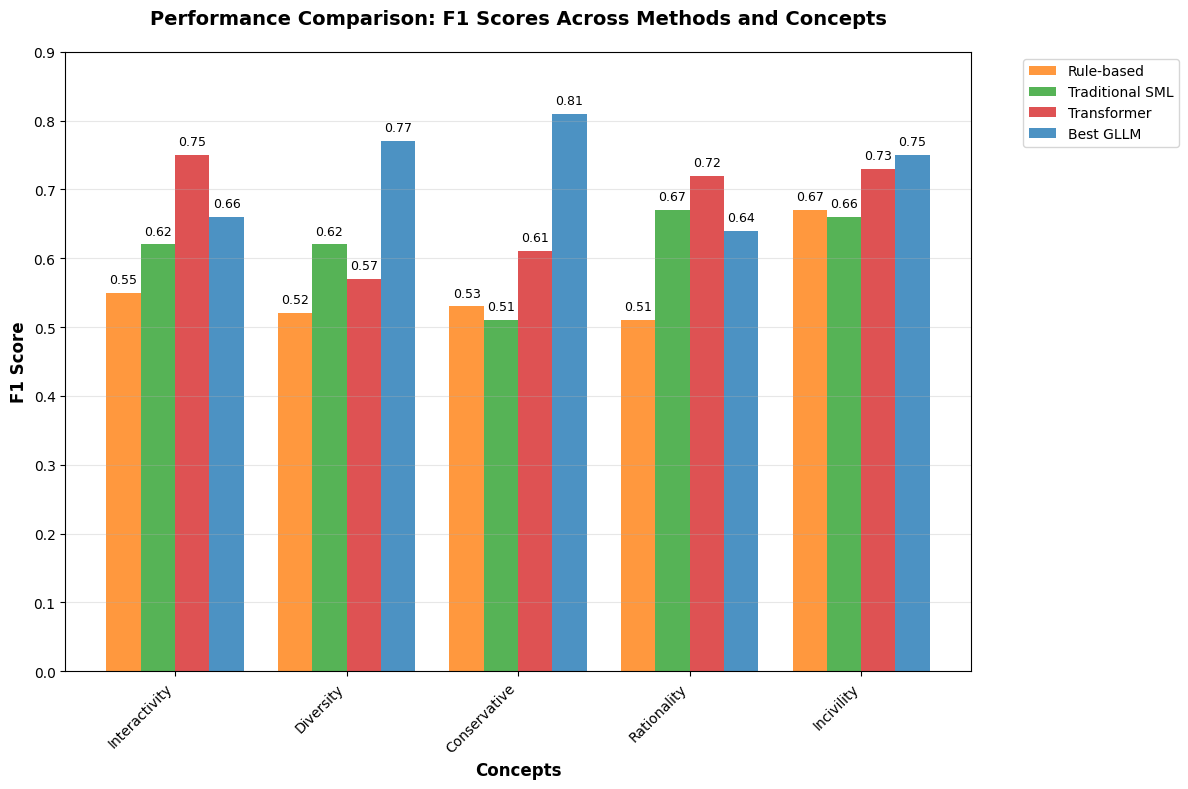

Performance Analysis Summary:
Interactivity: Best = Transformer (0.75)
Diversity: Best = Best GLLM (0.77)
Conservative: Best = Best GLLM (0.81)
Rationality: Best = Transformer (0.72)
Incivility: Best = Best GLLM (0.75)


In [26]:
# Create visualization for bestF1_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create DataFrame from the data
df_viz = pd.DataFrame(bestF1_data)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set positions for bars
x = np.arange(len(df_viz['Concept']))
width = 0.2  # Width of bars

# Create bars for each method
methods = ['Rule-based', 'Traditional SML', 'Transformer', 'Best GLLM']
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']

for i, method in enumerate(methods):
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, df_viz[method], width, label=method, color=colors[i], alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_xlabel('Concepts', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Comparison: F1 Scores Across Methods and Concepts', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_viz['Concept'], rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 0.9)

# Add some styling
plt.tight_layout()
plt.show()

print("Performance Analysis Summary:")
print("=" * 50)
for concept in df_viz['Concept']:
    row = df_viz[df_viz['Concept'] == concept].iloc[0]
    best_method = methods[np.argmax([row[method] for method in methods])]
    best_score = max([row[method] for method in methods])
    print(f"{concept}: Best = {best_method} ({best_score:.2f})")

In [ ]:
#plot Table 2. Accuracy, Precision, Recall and F1 scores of interactivity measures against the manually coded interactivity on the test set.

# Performance data converted from table to dictionary format
performance_table = {
    'Rule-based (Mentions of @)': {
        'class_0': {
            'label': 'Non-Interactive',
            'precision': 0.75,
            'recall': 0.83,
            'f1_score': 0.79,
            'n': 559
        },
        'class_1': {
            'label': 'Interactive', 
            'precision': 0.38,
            'recall': 0.28,
            'f1_score': 0.32,
            'n': 214
        },
        'accuracy': 0.68,
        'macro_average': {
            'precision': 0.57,
            'recall': 0.55,
            'f1_score': 0.55,
            'n': 773
        }
    },
    'SML (Logistic Regression)': {
        'class_0': {
            'label': 'Non-Interactive',
            'precision': 0.88,
            'recall': 0.57,
            'f1_score': 0.69,
            'n': 559
        },
        'class_1': {
            'label': 'Interactive',
            'precision': 0.42,
            'recall': 0.80,
            'f1_score': 0.55,
            'n': 214
        },
        'accuracy': 0.64,
        'macro_average': {
            'precision': 0.65,
            'recall': 0.69,
            'f1_score': 0.62,
            'n': 773
        }
    },
    'Transformer': {
        'class_0': {
            'label': 'Non-Interactive',
            'precision': 0.87,
            'recall': 0.84,
            'f1_score': 0.86,
            'n': 559
        },
        'class_1': {
            'label': 'Interactive',
            'precision': 0.62,
            'recall': 0.68,
            'f1_score': 0.65,
            'n': 214
        },
        'accuracy': 0.79,
        'macro_average': {
            'precision': 0.74,
            'recall': 0.76,
            'f1_score': 0.75,
            'n': 773
        }
    },
    'GLLM (Llama3.1:70b)': {
        'class_0': {
            'label': 'No',
            'precision': 0.85,
            'recall': 0.70,
            'f1_score': 0.77,
            'n': 559
        },
        'class_1': {
            'label': 'Yes',
            'precision': 0.46,
            'recall': 0.69,
            'f1_score': 0.55,
            'n': 214
        },
        'accuracy': 0.69,
        'macro_average': {
            'precision': 0.66,
            'recall': 0.69,
            'f1_score': 0.66,
            'n': 773
        }
    }
}


Performance Table Dictionary:

Rule-based (Mentions of @):
  Macro F1: 0.55
  Accuracy: 0.68
  Class 0 F1: 0.79
  Class 1 F1: 0.32

SML (Logistic Regression):
  Macro F1: 0.62
  Accuracy: 0.64
  Class 0 F1: 0.69
  Class 1 F1: 0.55

Transformer:
  Macro F1: 0.75
  Accuracy: 0.79
  Class 0 F1: 0.86
  Class 1 F1: 0.65

GLLM (Llama3.1:70b):
  Macro F1: 0.66
  Accuracy: 0.69
  Class 0 F1: 0.77
  Class 1 F1: 0.55

Macro F1 Scores Summary:
------------------------------
Rule-based (Mentions of @): 0.55
SML (Logistic Regression): 0.62
Transformer: 0.75
GLLM (Llama3.1:70b): 0.66

Best performing method: Transformer (0.75)


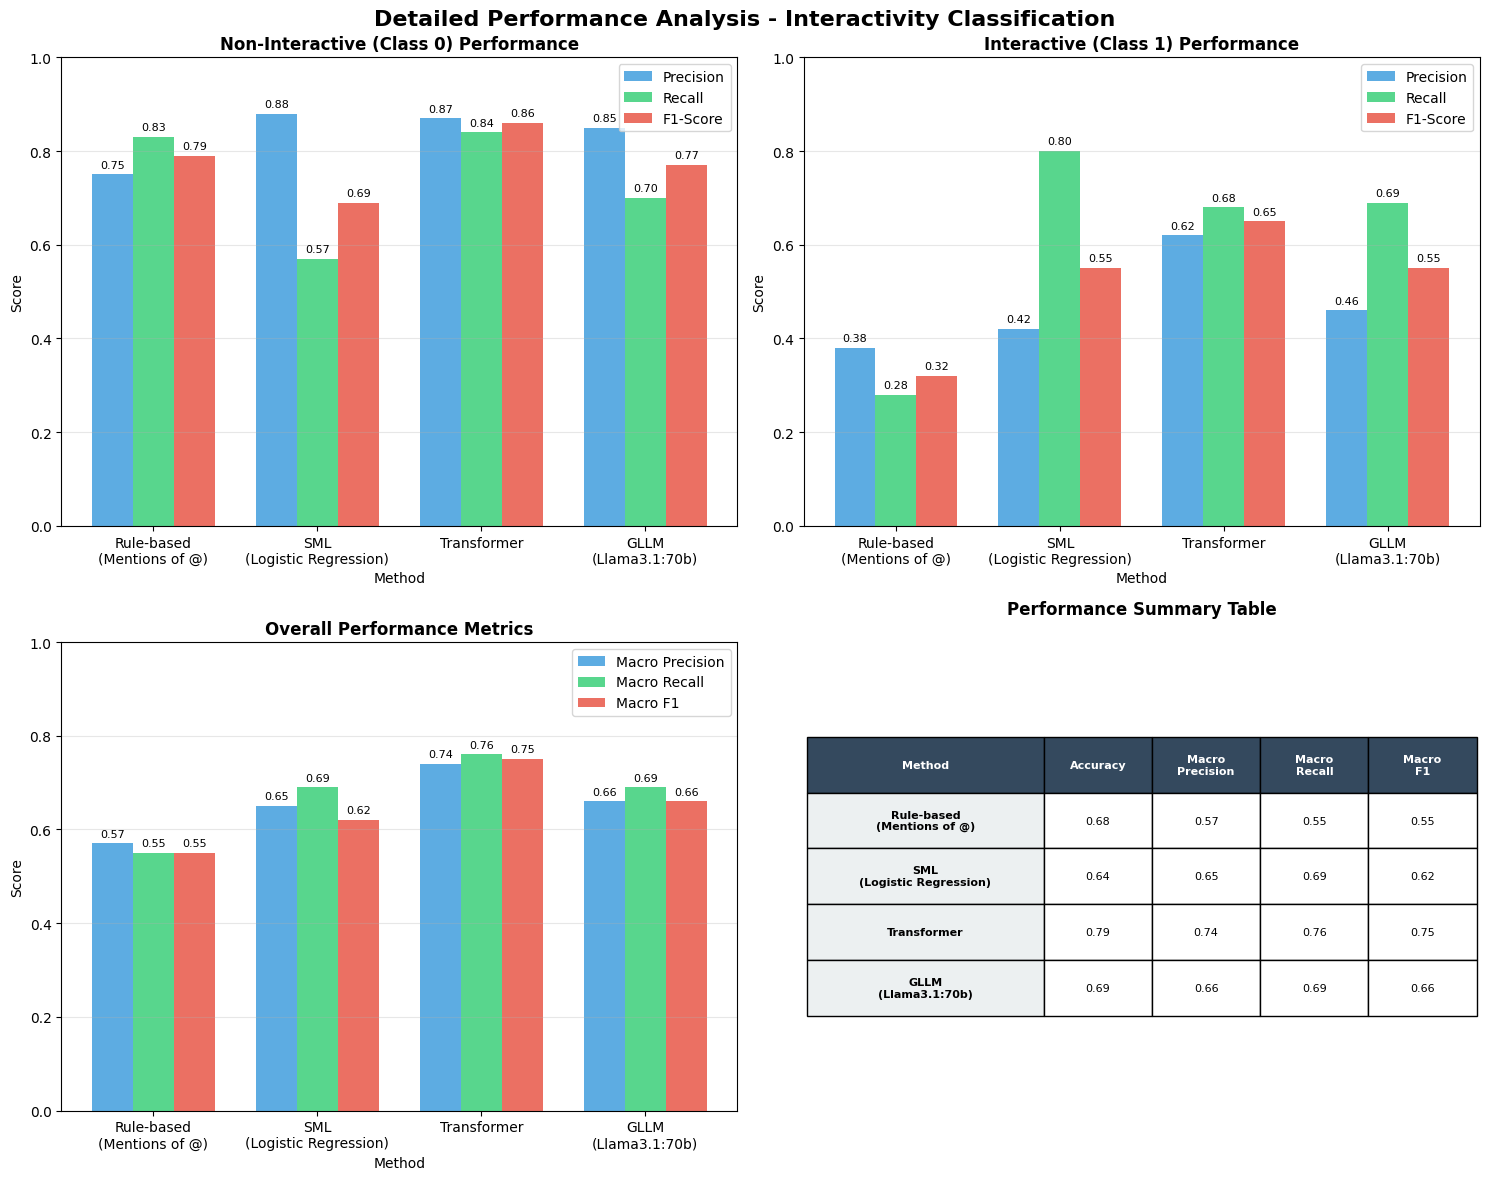


INTERACTIVITY CLASSIFICATION ANALYSIS INSIGHTS
• Best Macro F1: Transformer (0.75)
• Best Accuracy: Transformer (0.79)

• Class Imbalance Impact:
  - Average Non-Interactive F1: 0.78
  - Average Interactive F1: 0.52
  - Difference: 0.26


In [56]:
# Visualize the detailed performance table

# Extract data for visualization
methods = list(performance_table.keys())
metrics = ['Precision', 'Recall', 'F1-Score']

# Prepare data for Class 0 and Class 1
class_0_data = {
    'Method': methods,
    'Precision': [performance_table[method]['class_0']['precision'] for method in methods],
    'Recall': [performance_table[method]['class_0']['recall'] for method in methods],
    'F1-Score': [performance_table[method]['class_0']['f1_score'] for method in methods],
    'Label': [performance_table[method]['class_0']['label'] for method in methods]
}

class_1_data = {
    'Method': methods,
    'Precision': [performance_table[method]['class_1']['precision'] for method in methods],
    'Recall': [performance_table[method]['class_1']['recall'] for method in methods],
    'F1-Score': [performance_table[method]['class_1']['f1_score'] for method in methods],
    'Label': [performance_table[method]['class_1']['label'] for method in methods]
}

# Extract macro metrics for overall performance
macro_precision = [performance_table[method]['macro_average']['precision'] for method in methods]
macro_recall = [performance_table[method]['macro_average']['recall'] for method in methods]
macro_f1 = [performance_table[method]['macro_average']['f1_score'] for method in methods]
accuracy = [performance_table[method]['accuracy'] for method in methods]

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed Performance Analysis - Interactivity Classification', fontsize=16, fontweight='bold')

# Set up bar positions
x = np.arange(len(methods))
width = 0.25

# Colors for different metrics
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Get class labels
class0_label = class_0_data["Label"][0]
class1_label = class_1_data["Label"][0]

# 1. Class 0 Performance (precision, recall, F1)
bars1_1 = ax1.bar(x - width, class_0_data['Precision'], width, label='Precision', color='#3498db', alpha=0.8)
bars1_2 = ax1.bar(x, class_0_data['Recall'], width, label='Recall', color='#2ecc71', alpha=0.8)
bars1_3 = ax1.bar(x + width, class_0_data['F1-Score'], width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax1.set_title(f'{class0_label} (Class 0) Performance', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Method')
ax1.set_xticks(x)
ax1.set_xticklabels([method.replace(' (', '\n(') for method in methods], rotation=0, ha='center')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1_1, bars1_2, bars1_3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Class 1 Performance (precision, recall, F1)
bars2_1 = ax2.bar(x - width, class_1_data['Precision'], width, label='Precision', color='#3498db', alpha=0.8)
bars2_2 = ax2.bar(x, class_1_data['Recall'], width, label='Recall', color='#2ecc71', alpha=0.8)
bars2_3 = ax2.bar(x + width, class_1_data['F1-Score'], width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax2.set_title(f'{class1_label} (Class 1) Performance', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xlabel('Method')
ax2.set_xticks(x)
ax2.set_xticklabels([method.replace(' (', '\n(') for method in methods], rotation=0, ha='center')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars2_1, bars2_2, bars2_3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Overall Performance Metrics (without accuracy)
bars3_1 = ax3.bar(x - width, macro_precision, width, label='Macro Precision', color='#3498db', alpha=0.8)
bars3_2 = ax3.bar(x, macro_recall, width, label='Macro Recall', color='#2ecc71', alpha=0.8)
bars3_3 = ax3.bar(x + width, macro_f1, width, label='Macro F1', color='#e74c3c', alpha=0.8)
ax3.set_title('Overall Performance Metrics', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Method')
ax3.set_xticks(x)
ax3.set_xticklabels([method.replace(' (', '\n(') for method in methods], rotation=0, ha='center')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars3_1, bars3_2, bars3_3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 4. Summary Table
ax4.axis('tight')
ax4.axis('off')
ax4.set_title('Performance Summary Table', fontweight='bold', pad=20)

# Create table data
table_data = []
for method in methods:
    method_display = method
    if 'Rule-based' in method:
        method_display = 'Rule-based\n(Mentions of @)'
    elif 'SML' in method:
        method_display = 'SML\n(Logistic Regression)'
    elif 'GLLM' in method:
        method_display = 'GLLM\n(Llama3.1:70b)'
    
    table_data.append([
        method_display,
        f"{performance_table[method]['accuracy']:.2f}",
        f"{performance_table[method]['macro_average']['precision']:.2f}",
        f"{performance_table[method]['macro_average']['recall']:.2f}",
        f"{performance_table[method]['macro_average']['f1_score']:.2f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Method', 'Accuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.16, 0.16, 0.16, 0.16])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 3)

# Style the table
for i in range(len(methods) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white', wrap=True)
        else:
            if j == 0:  # Method name column
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold', wrap=True)
            else:
                cell.set_facecolor('#ffffff')

plt.tight_layout()
plt.show()

# Print summary insights
print("\n" + "="*60)
print("INTERACTIVITY CLASSIFICATION ANALYSIS INSIGHTS")
print("="*60)

best_macro_f1 = max(macro_f1)
best_macro_method = methods[macro_f1.index(best_macro_f1)]
print(f"• Best Macro F1: {best_macro_method} ({best_macro_f1:.2f})")

best_accuracy = max(accuracy)
best_acc_method = methods[accuracy.index(best_accuracy)]
print(f"• Best Accuracy: {best_acc_method} ({best_accuracy:.2f})")

print(f"\n• Class Imbalance Impact:")
avg_class0_f1 = np.mean(class_0_data['F1-Score'])
avg_class1_f1 = np.mean(class_1_data['F1-Score'])
print(f"  - Average {class0_label} F1: {avg_class0_f1:.2f}")
print(f"  - Average {class1_label} F1: {avg_class1_f1:.2f}")
print(f"  - Difference: {abs(avg_class0_f1 - avg_class1_f1):.2f}")

In [40]:
# Liberal/Non-liberal Classification Performance Table Dictionary
# Table: Accuracy, Precision, Recall and F1 scores of liberal measures against the manually coded liberal on the test set

liberal_performance_table = {
    'Rule-based (MFD 2.0)': {
        'class_0': {
            'label': 'Non-liberal',
            'precision': 0.83,
            'recall': 0.71,
            'f1_score': 0.77,
            'n': 633
        },
        'class_1': {
            'label': 'Liberal',
            'precision': 0.22,
            'recall': 0.36,
            'f1_score': 0.27,
            'n': 140
        },
        'accuracy': 0.65,
        'macro_average': {
            'precision': 0.52,
            'recall': 0.53,
            'f1_score': 0.52,
            'n': 773
        }
    },
    'SML (Logistic Regression)': {
        'class_0': {
            'label': 'Non-liberal',
            'precision': 0.90,
            'recall': 0.71,
            'f1_score': 0.80,
            'n': 633
        },
        'class_1': {
            'label': 'Liberal',
            'precision': 0.33,
            'recall': 0.66,
            'f1_score': 0.44,
            'n': 140
        },
        'accuracy': 0.70,
        'macro_average': {
            'precision': 0.62,
            'recall': 0.68,
            'f1_score': 0.62,
            'n': 773
        }
    },
    'Transformer': {
        'class_0': {
            'label': 'Non-liberal',
            'precision': 0.92,
            'recall': 0.59,
            'f1_score': 0.72,
            'n': 633
        },
        'class_1': {
            'label': 'Liberal',
            'precision': 0.30,
            'recall': 0.78,
            'f1_score': 0.43,
            'n': 140
        },
        'accuracy': 0.62,
        'macro_average': {
            'precision': 0.61,
            'recall': 0.68,
            'f1_score': 0.57,
            'n': 773
        }
    },
    'GLLM (Llama3.1:70b)': {
        'class_0': {
            'label': 'Non-liberal',
            'precision': 0.95,
            'recall': 0.85,
            'f1_score': 0.90,
            'n': 633
        },
        'class_1': {
            'label': 'Liberal',
            'precision': 0.54,
            'recall': 0.81,
            'f1_score': 0.65,
            'n': 140
        },
        'accuracy': 0.84,
        'macro_average': {
            'precision': 0.75,
            'recall': 0.83,
            'f1_score': 0.77,
            'n': 773
        }
    }
}


In [41]:
# Conservative/Non-conservative Classification Performance Table Dictionary
# Table: Accuracy, Precision, Recall and F1 scores of conservative measures against the manually coded conservative on the test set

conservative_performance_table = {
    'Rule-based (MFD 2.0)': {
        'class_0': {
            'label': 'Non-conservative',
            'precision': 0.88,
            'recall': 0.66,
            'f1_score': 0.75,
            'n': 660
        },
        'class_1': {
            'label': 'Conservative',
            'precision': 0.19,
            'recall': 0.49,
            'f1_score': 0.28,
            'n': 113
        },
        'accuracy': 0.63,
        'macro_average': {
            'precision': 0.54,
            'recall': 0.57,
            'f1_score': 0.51,
            'n': 773
        }
    },
    'SML (Logistic Regression)': {
        'class_0': {
            'label': 'Non-conservative',
            'precision': 0.93,
            'recall': 0.54,
            'f1_score': 0.68,
            'n': 660
        },
        'class_1': {
            'label': 'Conservative',
            'precision': 0.22,
            'recall': 0.75,
            'f1_score': 0.34,
            'n': 113
        },
        'accuracy': 0.57,
        'macro_average': {
            'precision': 0.57,
            'recall': 0.65,
            'f1_score': 0.51,
            'n': 773
        }
    },
    'Transformer': {
        'class_0': {
            'label': 'Non-conservative',
            'precision': 0.89,
            'recall': 0.84,
            'f1_score': 0.87,
            'n': 660
        },
        'class_1': {
            'label': 'Conservative',
            'precision': 0.31,
            'recall': 0.41,
            'f1_score': 0.35,
            'n': 113
        },
        'accuracy': 0.78,
        'macro_average': {
            'precision': 0.60,
            'recall': 0.63,
            'f1_score': 0.61,
            'n': 773
        }
    },
    'GLLM (Llama3.1:70b)': {
        'class_0': {
            'label': 'Non-conservative',
            'precision': 0.96,
            'recall': 0.91,
            'f1_score': 0.93,
            'n': 660
        },
        'class_1': {
            'label': 'Conservative',
            'precision': 0.60,
            'recall': 0.80,
            'f1_score': 0.68,
            'n': 113
        },
        'accuracy': 0.89,
        'macro_average': {
            'precision': 0.78,
            'recall': 0.85,
            'f1_score': 0.81,
            'n': 773
        }
    }
}



In [48]:
# Rationality Classification Performance Table Dictionary
# Table: Accuracy, Precision, Recall and F1 scores of rationality measures against the manually coded rationality on the test set

rationality_performance_table = {
    'Rule-based (FK-score)': {
        'class_0': {
            'label': 'Non-rational',
            'precision': 0.84,
            'recall': 0.59,
            'f1_score': 0.69,
            'n': 624
        },
        'class_1': {
            'label': 'Rational',
            'precision': 0.24,
            'recall': 0.53,
            'f1_score': 0.33,
            'n': 149
        },
        'accuracy': 0.58,
        'macro_average': {
            'precision': 0.54,
            'recall': 0.56,
            'f1_score': 0.51,
            'n': 773
        }
    },
    'SML (SVC "rbf")': {
        'class_0': {
            'label': 'Non-rational',
            'precision': 0.91,
            'recall': 0.78,
            'f1_score': 0.83,
            'n': 624
        },
        'class_1': {
            'label': 'Rational',
            'precision': 0.41,
            'recall': 0.66,
            'f1_score': 0.51,
            'n': 149
        },
        'accuracy': 0.75,
        'macro_average': {
            'precision': 0.66,
            'recall': 0.72,
            'f1_score': 0.67,
            'n': 773
        }
    },
    'Transformer': {
        'class_0': {
            'label': 'Non-rational',
            'precision': 0.89,
            'recall': 0.88,
            'f1_score': 0.89,
            'n': 624
        },
        'class_1': {
            'label': 'Rational',
            'precision': 0.54,
            'recall': 0.56,
            'f1_score': 0.55,
            'n': 149
        },
        'accuracy': 0.82,
        'macro_average': {
            'precision': 0.72,
            'recall': 0.72,
            'f1_score': 0.72,
            'n': 773
        }
    },
    'GLLM (Llama3.1:70b)': {
        'class_0': {
            'label': 'No',
            'precision': 0.85,
            'recall': 0.94,
            'f1_score': 0.89,
            'n': 624
        },
        'class_1': {
            'label': 'Yes',
            'precision': 0.56,
            'recall': 0.30,
            'f1_score': 0.39,
            'n': 149
        },
        'accuracy': 0.82,
        'macro_average': {
            'precision': 0.70,
            'recall': 0.62,
            'f1_score': 0.64,
            'n': 773
        }
    }
}



In [43]:
# Incivility Classification Performance Table Dictionary
# Table: Accuracy, Precision, Recall and F1 scores of incivility measures against the manually coded incivility on the test set

incivility_performance_table = {
    'Rule-based (Ksiazek\'s hostility dictionary)': {
        'class_0': {
            'label': 'Civil',
            'precision': 0.65,
            'recall': 0.86,
            'f1_score': 0.74,
            'n': 408
        },
        'class_1': {
            'label': 'Uncivil',
            'precision': 0.76,
            'recall': 0.49,
            'f1_score': 0.59,
            'n': 365
        },
        'accuracy': 0.68,
        'macro_average': {
            'precision': 0.71,
            'recall': 0.67,
            'f1_score': 0.67,
            'n': 773
        }
    },
    'SML (SVC "rbf")': {
        'class_0': {
            'label': 'Civil',
            'precision': 0.74,
            'recall': 0.55,
            'f1_score': 0.63,
            'n': 408
        },
        'class_1': {
            'label': 'Uncivil',
            'precision': 0.61,
            'recall': 0.79,
            'f1_score': 0.69,
            'n': 365
        },
        'accuracy': 0.66,
        'macro_average': {
            'precision': 0.67,
            'recall': 0.67,
            'f1_score': 0.66,
            'n': 773
        }
    },
    'Transformer': {
        'class_0': {
            'label': 'Civil',
            'precision': 0.74,
            'recall': 0.75,
            'f1_score': 0.75,
            'n': 408
        },
        'class_1': {
            'label': 'Uncivil',
            'precision': 0.72,
            'recall': 0.70,
            'f1_score': 0.71,
            'n': 365
        },
        'accuracy': 0.73,
        'macro_average': {
            'precision': 0.73,
            'recall': 0.73,
            'f1_score': 0.73,
            'n': 773
        }
    },
    'GLLM (Llama3.1:70b)': {
        'class_0': {
            'label': 'Civil',
            'precision': 0.86,
            'recall': 0.64,
            'f1_score': 0.74,
            'n': 408
        },
        'class_1': {
            'label': 'Uncivil',
            'precision': 0.69,
            'recall': 0.88,
            'f1_score': 0.77,
            'n': 365
        },
        'accuracy': 0.76,
        'macro_average': {
            'precision': 0.77,
            'recall': 0.76,
            'f1_score': 0.75,
            'n': 773
        }
    }
}



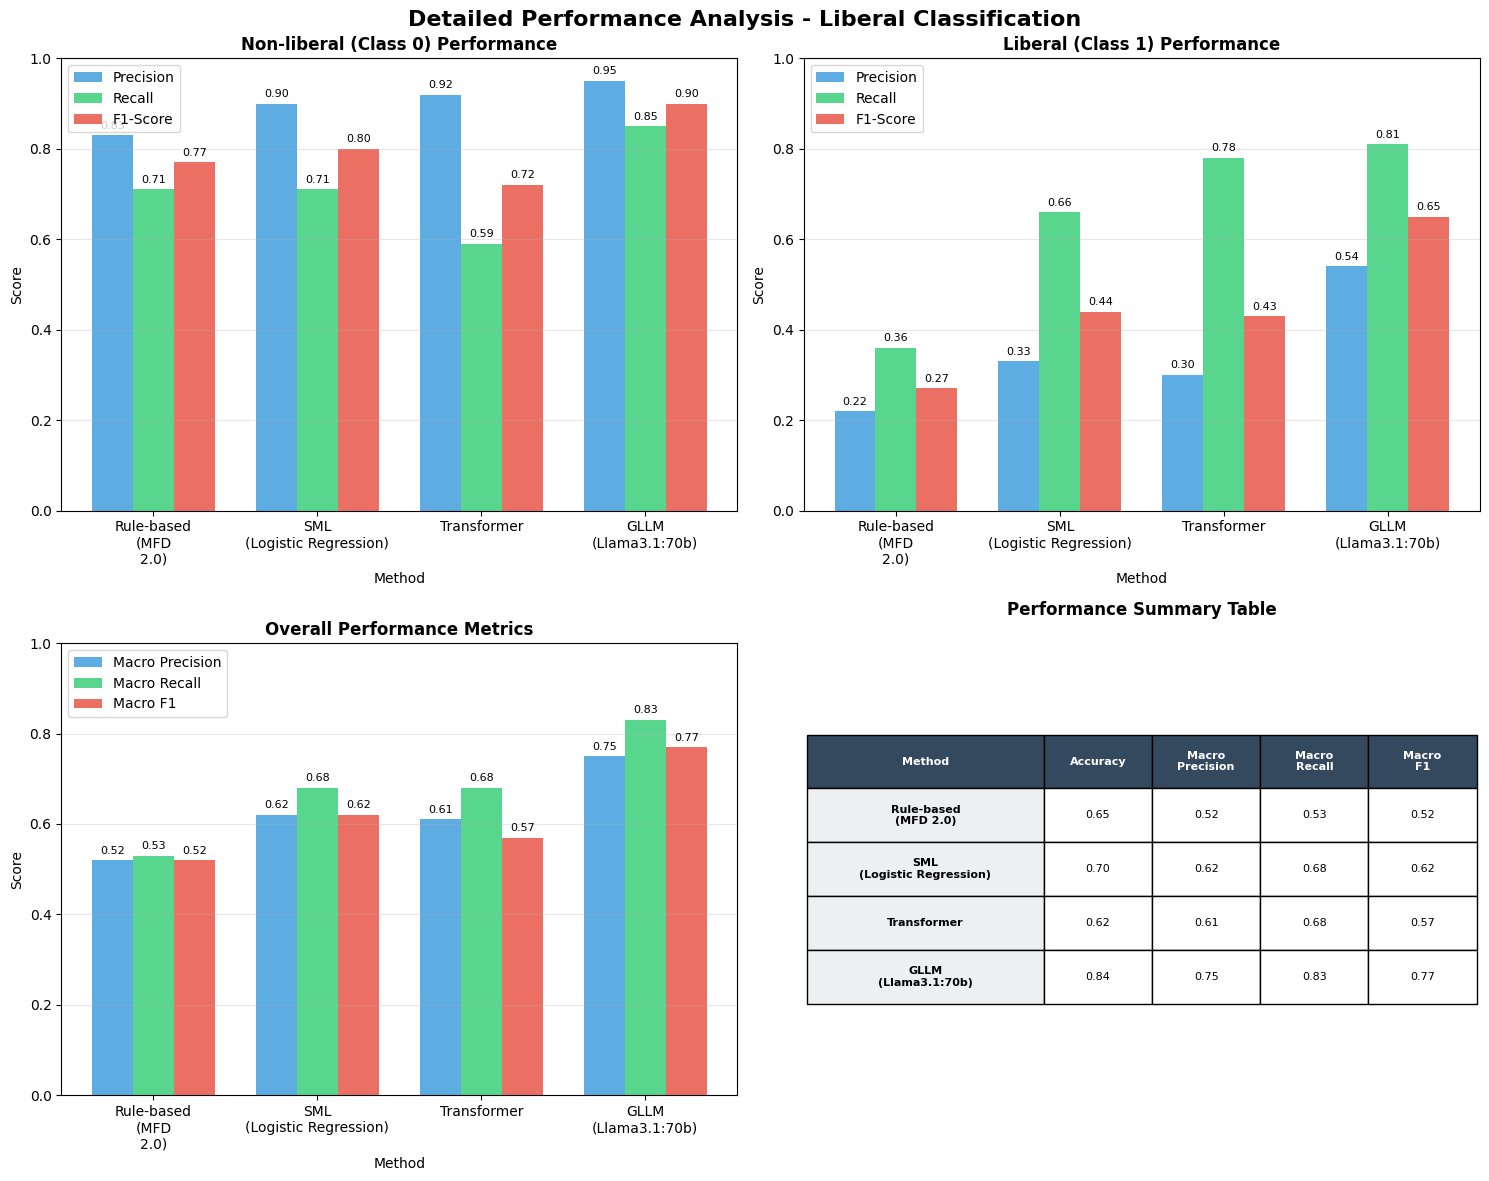


LIBERAL CLASSIFICATION ANALYSIS INSIGHTS
• Best Macro F1: GLLM (Llama3.1:70b) (0.77)
• Best Accuracy: GLLM (Llama3.1:70b) (0.84)

• Class Imbalance Impact:
  - Average Non-liberal F1: 0.80
  - Average Liberal F1: 0.45
  - Difference: 0.35 (Non-liberal performs better)


In [52]:
# Visualization of Liberal Classification Performance Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract data from liberal_performance_table for visualization
liberal_methods = list(liberal_performance_table.keys())
liberal_macro_f1_values = [liberal_performance_table[method]['macro_average']['f1_score'] for method in liberal_methods]
liberal_accuracy_values = [liberal_performance_table[method]['accuracy'] for method in liberal_methods]
liberal_class0_f1_values = [liberal_performance_table[method]['class_0']['f1_score'] for method in liberal_methods]
liberal_class1_f1_values = [liberal_performance_table[method]['class_1']['f1_score'] for method in liberal_methods]

# Extract precision and recall for individual classes
liberal_class0_precision = [liberal_performance_table[method]['class_0']['precision'] for method in liberal_methods]
liberal_class0_recall = [liberal_performance_table[method]['class_0']['recall'] for method in liberal_methods]
liberal_class1_precision = [liberal_performance_table[method]['class_1']['precision'] for method in liberal_methods]
liberal_class1_recall = [liberal_performance_table[method]['class_1']['recall'] for method in liberal_methods]
liberal_macro_precision = [liberal_performance_table[method]['macro_average']['precision'] for method in liberal_methods]
liberal_macro_recall = [liberal_performance_table[method]['macro_average']['recall'] for method in liberal_methods]

# Create a comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed Performance Analysis - Liberal Classification', fontsize=16, fontweight='bold')

# Colors for consistency
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Get class labels from the first method
class0_label = liberal_performance_table[liberal_methods[0]]['class_0']['label']
class1_label = liberal_performance_table[liberal_methods[0]]['class_1']['label']

# 1. Class 0 Performance (precision, recall, F1)
x = np.arange(len(liberal_methods))
width = 0.25
bars1_1 = ax1.bar(x - width, liberal_class0_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars1_2 = ax1.bar(x, liberal_class0_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars1_3 = ax1.bar(x + width, liberal_class0_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax1.set_title(f'{class0_label} (Class 0) Performance', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Method')
ax1.set_xticks(x)
ax1.set_xticklabels([method.replace(' (', '\n(').replace('MFD 2.0', 'MFD\n2.0') for method in liberal_methods], rotation=0, ha='center')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1_1, bars1_2, bars1_3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Class 1 Performance (precision, recall, F1)
bars2_1 = ax2.bar(x - width, liberal_class1_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars2_2 = ax2.bar(x, liberal_class1_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars2_3 = ax2.bar(x + width, liberal_class1_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax2.set_title(f'{class1_label} (Class 1) Performance', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xlabel('Method')
ax2.set_xticks(x)
ax2.set_xticklabels([method.replace(' (', '\n(').replace('MFD 2.0', 'MFD\n2.0') for method in liberal_methods], rotation=0, ha='center')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars2_1, bars2_2, bars2_3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Overall Performance Metrics (without accuracy)
bars3_1 = ax3.bar(x - width, liberal_macro_precision, width, label='Macro Precision', color='#3498db', alpha=0.8)
bars3_2 = ax3.bar(x, liberal_macro_recall, width, label='Macro Recall', color='#2ecc71', alpha=0.8)
bars3_3 = ax3.bar(x + width, liberal_macro_f1_values, width, label='Macro F1', color='#e74c3c', alpha=0.8)
ax3.set_title('Overall Performance Metrics', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Method')
ax3.set_xticks(x)
ax3.set_xticklabels([method.replace(' (', '\n(').replace('MFD 2.0', 'MFD\n2.0') for method in liberal_methods], rotation=0, ha='center')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars3_1, bars3_2, bars3_3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 4. Summary Table
ax4.axis('tight')
ax4.axis('off')
ax4.set_title('Performance Summary Table', fontweight='bold', pad=20)

# Create table data
table_data = []
for method in liberal_methods:
    method_display = method
    if 'Rule-based' in method:
        method_display = 'Rule-based\n(MFD 2.0)'
    elif 'SML' in method:
        method_display = 'SML\n(Logistic Regression)'
    elif 'GLLM' in method:
        method_display = 'GLLM\n(Llama3.1:70b)'
    
    table_data.append([
        method_display,
        f"{liberal_performance_table[method]['accuracy']:.2f}",
        f"{liberal_performance_table[method]['macro_average']['precision']:.2f}",
        f"{liberal_performance_table[method]['macro_average']['recall']:.2f}",
        f"{liberal_performance_table[method]['macro_average']['f1_score']:.2f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Method', 'Accuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.16, 0.16, 0.16, 0.16])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 3)

# Style the table
for i in range(len(liberal_methods) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white', wrap=True)
        else:
            if j == 0:  # Method name column
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold', wrap=True)
            else:
                cell.set_facecolor('#ffffff')

plt.tight_layout()
plt.show()

# Print summary insights
print("\n" + "="*60)
print("LIBERAL CLASSIFICATION ANALYSIS INSIGHTS")
print("="*60)

best_macro_f1 = max(liberal_macro_f1_values)
best_macro_method = liberal_methods[liberal_macro_f1_values.index(best_macro_f1)]
print(f"• Best Macro F1: {best_macro_method} ({best_macro_f1:.2f})")

best_accuracy = max(liberal_accuracy_values)
best_acc_method = liberal_methods[liberal_accuracy_values.index(best_accuracy)]
print(f"• Best Accuracy: {best_acc_method} ({best_accuracy:.2f})")

print(f"\n• Class Imbalance Impact:")
avg_class0_f1 = np.mean(liberal_class0_f1_values)
avg_class1_f1 = np.mean(liberal_class1_f1_values)
print(f"  - Average {class0_label} F1: {avg_class0_f1:.2f}")
print(f"  - Average {class1_label} F1: {avg_class1_f1:.2f}")
print(f"  - Difference: {avg_class0_f1 - avg_class1_f1:.2f} ({class0_label} performs better)")

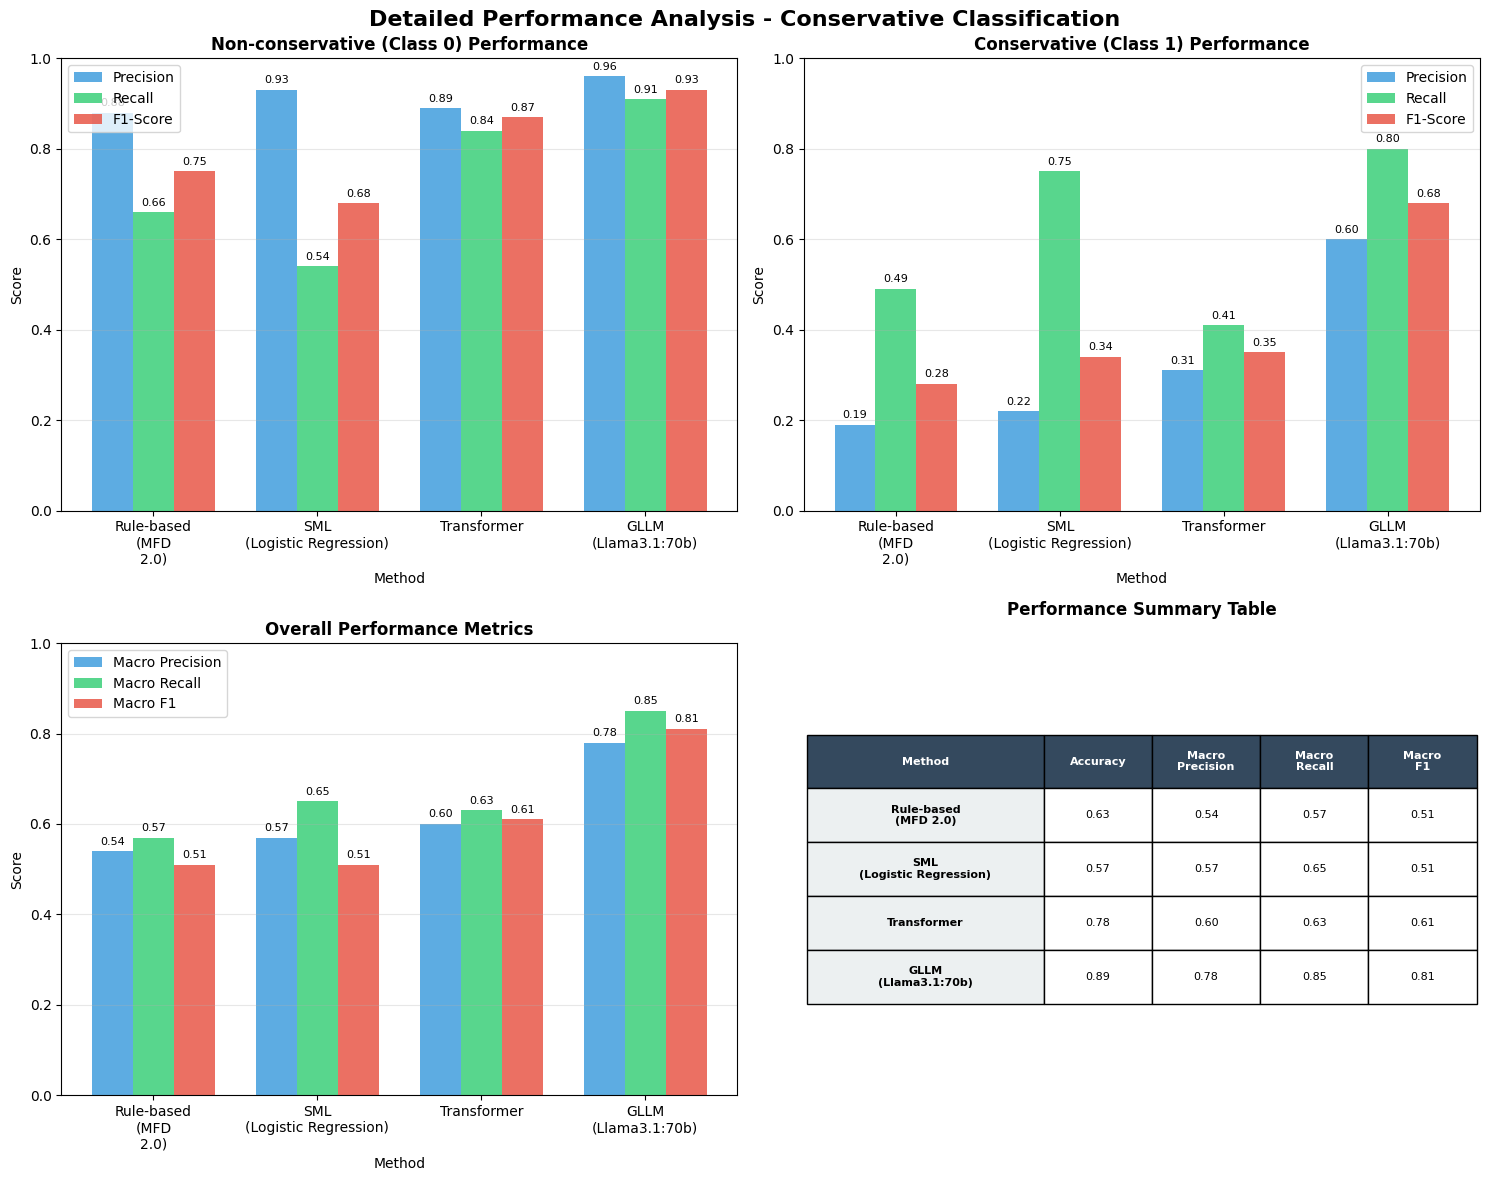


CONSERVATIVE CLASSIFICATION ANALYSIS INSIGHTS
• Best Macro F1: GLLM (Llama3.1:70b) (0.81)
• Best Accuracy: GLLM (Llama3.1:70b) (0.89)

• Class Imbalance Impact:
  - Average Non-conservative F1: 0.81
  - Average Conservative F1: 0.41
  - Difference: 0.40 (Non-conservative performs better)


In [53]:
# Visualization of Conservative Classification Performance Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract data from conservative_performance_table for visualization
conservative_methods = list(conservative_performance_table.keys())
conservative_macro_f1_values = [conservative_performance_table[method]['macro_average']['f1_score'] for method in conservative_methods]
conservative_accuracy_values = [conservative_performance_table[method]['accuracy'] for method in conservative_methods]
conservative_class0_f1_values = [conservative_performance_table[method]['class_0']['f1_score'] for method in conservative_methods]
conservative_class1_f1_values = [conservative_performance_table[method]['class_1']['f1_score'] for method in conservative_methods]

# Extract precision and recall for individual classes
conservative_class0_precision = [conservative_performance_table[method]['class_0']['precision'] for method in conservative_methods]
conservative_class0_recall = [conservative_performance_table[method]['class_0']['recall'] for method in conservative_methods]
conservative_class1_precision = [conservative_performance_table[method]['class_1']['precision'] for method in conservative_methods]
conservative_class1_recall = [conservative_performance_table[method]['class_1']['recall'] for method in conservative_methods]
conservative_macro_precision = [conservative_performance_table[method]['macro_average']['precision'] for method in conservative_methods]
conservative_macro_recall = [conservative_performance_table[method]['macro_average']['recall'] for method in conservative_methods]

# Create a comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed Performance Analysis - Conservative Classification', fontsize=16, fontweight='bold')

# Colors for consistency
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Get class labels from the first method
class0_label = conservative_performance_table[conservative_methods[0]]['class_0']['label']
class1_label = conservative_performance_table[conservative_methods[0]]['class_1']['label']

# 1. Class 0 Performance (precision, recall, F1)
x = np.arange(len(conservative_methods))
width = 0.25
bars1_1 = ax1.bar(x - width, conservative_class0_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars1_2 = ax1.bar(x, conservative_class0_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars1_3 = ax1.bar(x + width, conservative_class0_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax1.set_title(f'{class0_label} (Class 0) Performance', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Method')
ax1.set_xticks(x)
ax1.set_xticklabels([method.replace(' (', '\n(').replace('MFD 2.0', 'MFD\n2.0') for method in conservative_methods], rotation=0, ha='center')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1_1, bars1_2, bars1_3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Class 1 Performance (precision, recall, F1)
bars2_1 = ax2.bar(x - width, conservative_class1_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars2_2 = ax2.bar(x, conservative_class1_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars2_3 = ax2.bar(x + width, conservative_class1_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax2.set_title(f'{class1_label} (Class 1) Performance', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xlabel('Method')
ax2.set_xticks(x)
ax2.set_xticklabels([method.replace(' (', '\n(').replace('MFD 2.0', 'MFD\n2.0') for method in conservative_methods], rotation=0, ha='center')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars2_1, bars2_2, bars2_3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Overall Performance Metrics (without accuracy)
bars3_1 = ax3.bar(x - width, conservative_macro_precision, width, label='Macro Precision', color='#3498db', alpha=0.8)
bars3_2 = ax3.bar(x, conservative_macro_recall, width, label='Macro Recall', color='#2ecc71', alpha=0.8)
bars3_3 = ax3.bar(x + width, conservative_macro_f1_values, width, label='Macro F1', color='#e74c3c', alpha=0.8)
ax3.set_title('Overall Performance Metrics', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Method')
ax3.set_xticks(x)
ax3.set_xticklabels([method.replace(' (', '\n(').replace('MFD 2.0', 'MFD\n2.0') for method in conservative_methods], rotation=0, ha='center')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars3_1, bars3_2, bars3_3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 4. Summary Table
ax4.axis('tight')
ax4.axis('off')
ax4.set_title('Performance Summary Table', fontweight='bold', pad=20)

# Create table data
table_data = []
for method in conservative_methods:
    method_display = method
    if 'Rule-based' in method:
        method_display = 'Rule-based\n(MFD 2.0)'
    elif 'SML' in method:
        method_display = 'SML\n(Logistic Regression)'
    elif 'GLLM' in method:
        method_display = 'GLLM\n(Llama3.1:70b)'
    
    table_data.append([
        method_display,
        f"{conservative_performance_table[method]['accuracy']:.2f}",
        f"{conservative_performance_table[method]['macro_average']['precision']:.2f}",
        f"{conservative_performance_table[method]['macro_average']['recall']:.2f}",
        f"{conservative_performance_table[method]['macro_average']['f1_score']:.2f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Method', 'Accuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.16, 0.16, 0.16, 0.16])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 3)

# Style the table
for i in range(len(conservative_methods) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white', wrap=True)
        else:
            if j == 0:  # Method name column
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold', wrap=True)
            else:
                cell.set_facecolor('#ffffff')

plt.tight_layout()
plt.show()

# Print summary insights
print("\n" + "="*60)
print("CONSERVATIVE CLASSIFICATION ANALYSIS INSIGHTS")
print("="*60)

best_macro_f1 = max(conservative_macro_f1_values)
best_macro_method = conservative_methods[conservative_macro_f1_values.index(best_macro_f1)]
print(f"• Best Macro F1: {best_macro_method} ({best_macro_f1:.2f})")

best_accuracy = max(conservative_accuracy_values)
best_acc_method = conservative_methods[conservative_accuracy_values.index(best_accuracy)]
print(f"• Best Accuracy: {best_acc_method} ({best_accuracy:.2f})")

print(f"\n• Class Imbalance Impact:")
avg_class0_f1 = np.mean(conservative_class0_f1_values)
avg_class1_f1 = np.mean(conservative_class1_f1_values)
print(f"  - Average {class0_label} F1: {avg_class0_f1:.2f}")
print(f"  - Average {class1_label} F1: {avg_class1_f1:.2f}")
print(f"  - Difference: {avg_class0_f1 - avg_class1_f1:.2f} ({class0_label} performs better)")

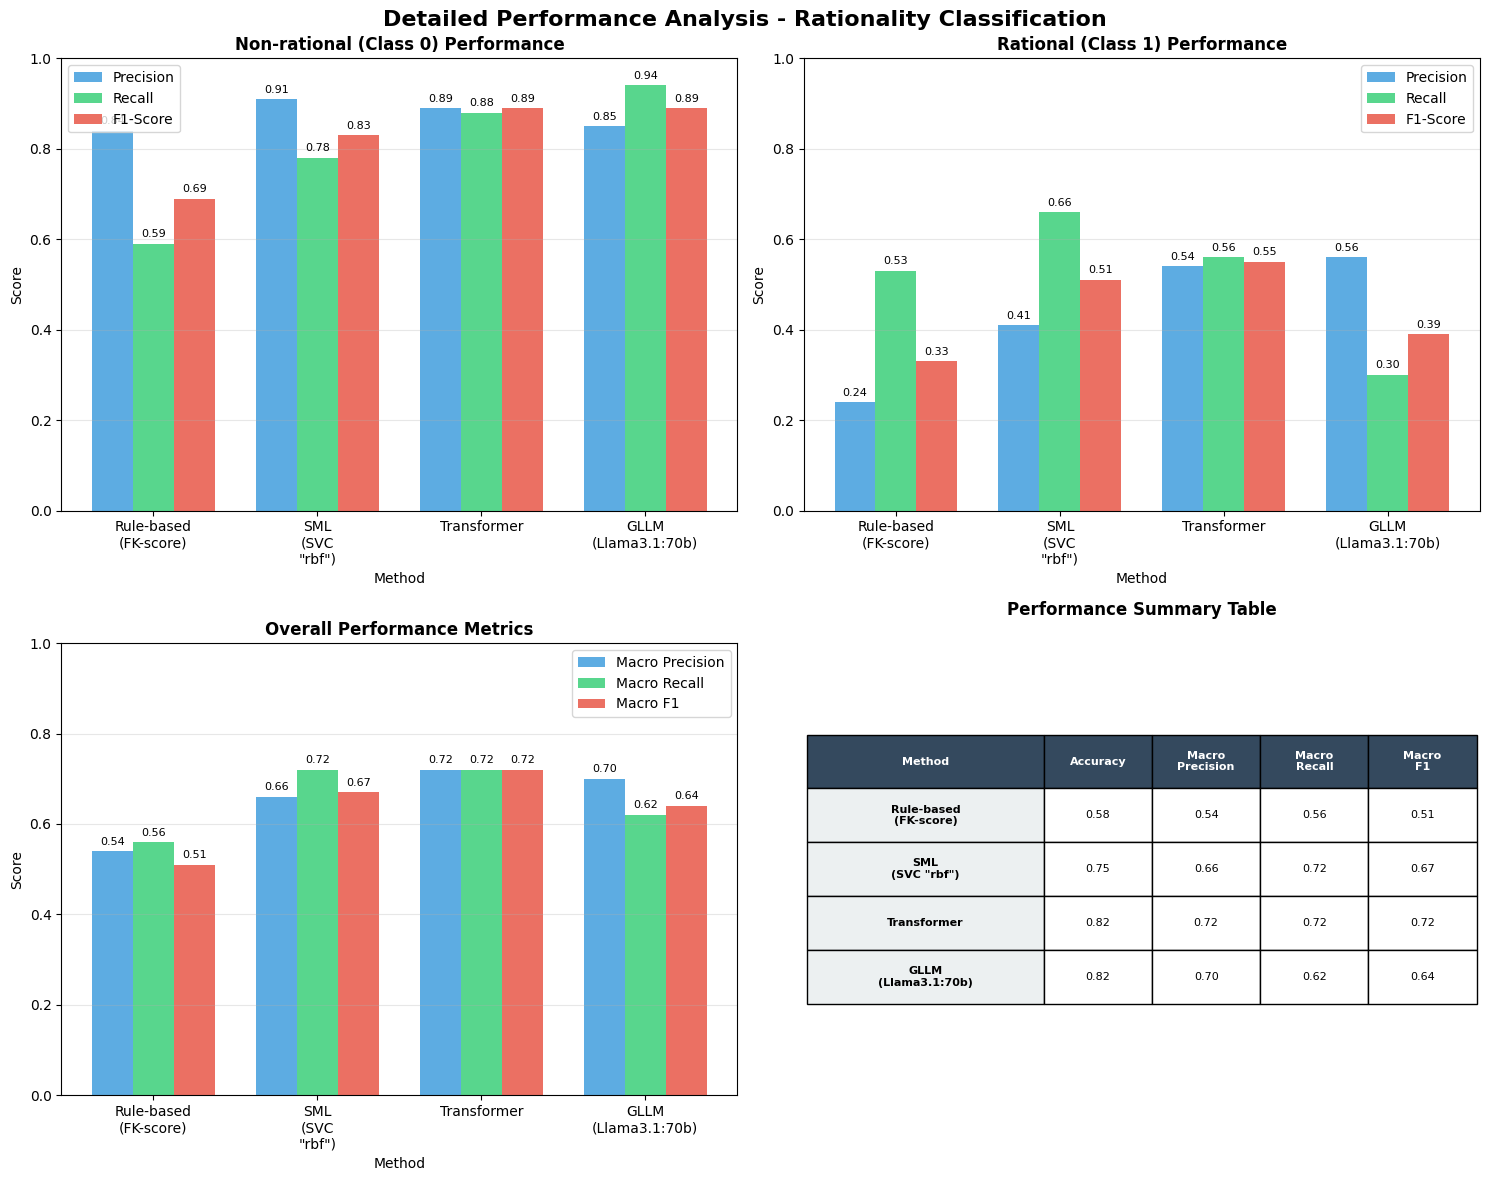


RATIONALITY CLASSIFICATION ANALYSIS INSIGHTS
• Best Macro F1: Transformer (0.72)
• Best Accuracy: Transformer (0.82)

• Class Imbalance Impact:
  - Average Non-rational F1: 0.83
  - Average Rational F1: 0.45
  - Difference: 0.38 (Non-rational performs better)


In [54]:
# Visualization of Rationality Classification Performance Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract data from rationality_performance_table for visualization
rationality_methods = list(rationality_performance_table.keys())
rationality_macro_f1_values = [rationality_performance_table[method]['macro_average']['f1_score'] for method in rationality_methods]
rationality_accuracy_values = [rationality_performance_table[method]['accuracy'] for method in rationality_methods]
rationality_class0_precision = [rationality_performance_table[method]['class_0']['precision'] for method in rationality_methods]
rationality_class0_recall = [rationality_performance_table[method]['class_0']['recall'] for method in rationality_methods]
rationality_class0_f1_values = [rationality_performance_table[method]['class_0']['f1_score'] for method in rationality_methods]
rationality_class1_precision = [rationality_performance_table[method]['class_1']['precision'] for method in rationality_methods]
rationality_class1_recall = [rationality_performance_table[method]['class_1']['recall'] for method in rationality_methods]
rationality_class1_f1_values = [rationality_performance_table[method]['class_1']['f1_score'] for method in rationality_methods]
rationality_macro_precision = [rationality_performance_table[method]['macro_average']['precision'] for method in rationality_methods]
rationality_macro_recall = [rationality_performance_table[method]['macro_average']['recall'] for method in rationality_methods]

# Create a comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed Performance Analysis - Rationality Classification', fontsize=16, fontweight='bold')

# Colors for consistency
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Get class labels from the first method
class0_label = rationality_performance_table[rationality_methods[0]]['class_0']['label']
class1_label = rationality_performance_table[rationality_methods[0]]['class_1']['label']

# 1. Class 0 Performance (precision, recall, F1)
x = np.arange(len(rationality_methods))
width = 0.25
bars1_1 = ax1.bar(x - width, rationality_class0_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars1_2 = ax1.bar(x, rationality_class0_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars1_3 = ax1.bar(x + width, rationality_class0_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax1.set_title(f'{class0_label} (Class 0) Performance', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Method')
ax1.set_xticks(x)
ax1.set_xticklabels([method.replace(' (', '\n(').replace('SVC "rbf"', 'SVC\n"rbf"') for method in rationality_methods], rotation=0, ha='center')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1_1, bars1_2, bars1_3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Class 1 Performance (precision, recall, F1)
bars2_1 = ax2.bar(x - width, rationality_class1_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars2_2 = ax2.bar(x, rationality_class1_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars2_3 = ax2.bar(x + width, rationality_class1_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax2.set_title(f'{class1_label} (Class 1) Performance', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xlabel('Method')
ax2.set_xticks(x)
ax2.set_xticklabels([method.replace(' (', '\n(').replace('SVC "rbf"', 'SVC\n"rbf"') for method in rationality_methods], rotation=0, ha='center')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars2_1, bars2_2, bars2_3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Overall Performance Metrics
bars3_1 = ax3.bar(x - width, rationality_macro_precision, width, label='Macro Precision', color='#3498db', alpha=0.8)
bars3_2 = ax3.bar(x, rationality_macro_recall, width, label='Macro Recall', color='#2ecc71', alpha=0.8)
bars3_3 = ax3.bar(x + width, rationality_macro_f1_values, width, label='Macro F1', color='#e74c3c', alpha=0.8)
ax3.set_title('Overall Performance Metrics', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Method')
ax3.set_xticks(x)
ax3.set_xticklabels([method.replace(' (', '\n(').replace('SVC "rbf"', 'SVC\n"rbf"') for method in rationality_methods], rotation=0, ha='center')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars3_1, bars3_2, bars3_3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 4. Summary Table
ax4.axis('tight')
ax4.axis('off')
ax4.set_title('Performance Summary Table', fontweight='bold', pad=20)

# Create table data
table_data = []
for method in rationality_methods:
    method_display = method
    if 'Rule-based' in method:
        method_display = 'Rule-based\n(FK-score)'
    elif 'SML' in method:
        method_display = 'SML\n(SVC "rbf")'
    elif 'GLLM' in method:
        method_display = 'GLLM\n(Llama3.1:70b)'
    
    table_data.append([
        method_display,
        f"{rationality_performance_table[method]['accuracy']:.2f}",
        f"{rationality_performance_table[method]['macro_average']['precision']:.2f}",
        f"{rationality_performance_table[method]['macro_average']['recall']:.2f}",
        f"{rationality_performance_table[method]['macro_average']['f1_score']:.2f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Method', 'Accuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.16, 0.16, 0.16, 0.16])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 3)

# Style the table
for i in range(len(rationality_methods) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white', wrap=True)
        else:
            if j == 0:  # Method name column
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold', wrap=True)
            else:
                cell.set_facecolor('#ffffff')

plt.tight_layout()
plt.show()

# Print summary insights
print("\n" + "="*60)
print("RATIONALITY CLASSIFICATION ANALYSIS INSIGHTS")
print("="*60)

best_macro_f1 = max(rationality_macro_f1_values)
best_macro_method = rationality_methods[rationality_macro_f1_values.index(best_macro_f1)]
print(f"• Best Macro F1: {best_macro_method} ({best_macro_f1:.2f})")

best_accuracy = max(rationality_accuracy_values)
best_acc_method = rationality_methods[rationality_accuracy_values.index(best_accuracy)]
print(f"• Best Accuracy: {best_acc_method} ({best_accuracy:.2f})")

print(f"\n• Class Imbalance Impact:")
avg_class0_f1 = np.mean(rationality_class0_f1_values)
avg_class1_f1 = np.mean(rationality_class1_f1_values)
print(f"  - Average {class0_label} F1: {avg_class0_f1:.2f}")
print(f"  - Average {class1_label} F1: {avg_class1_f1:.2f}")
print(f"  - Difference: {avg_class0_f1 - avg_class1_f1:.2f} ({class0_label} performs better)")

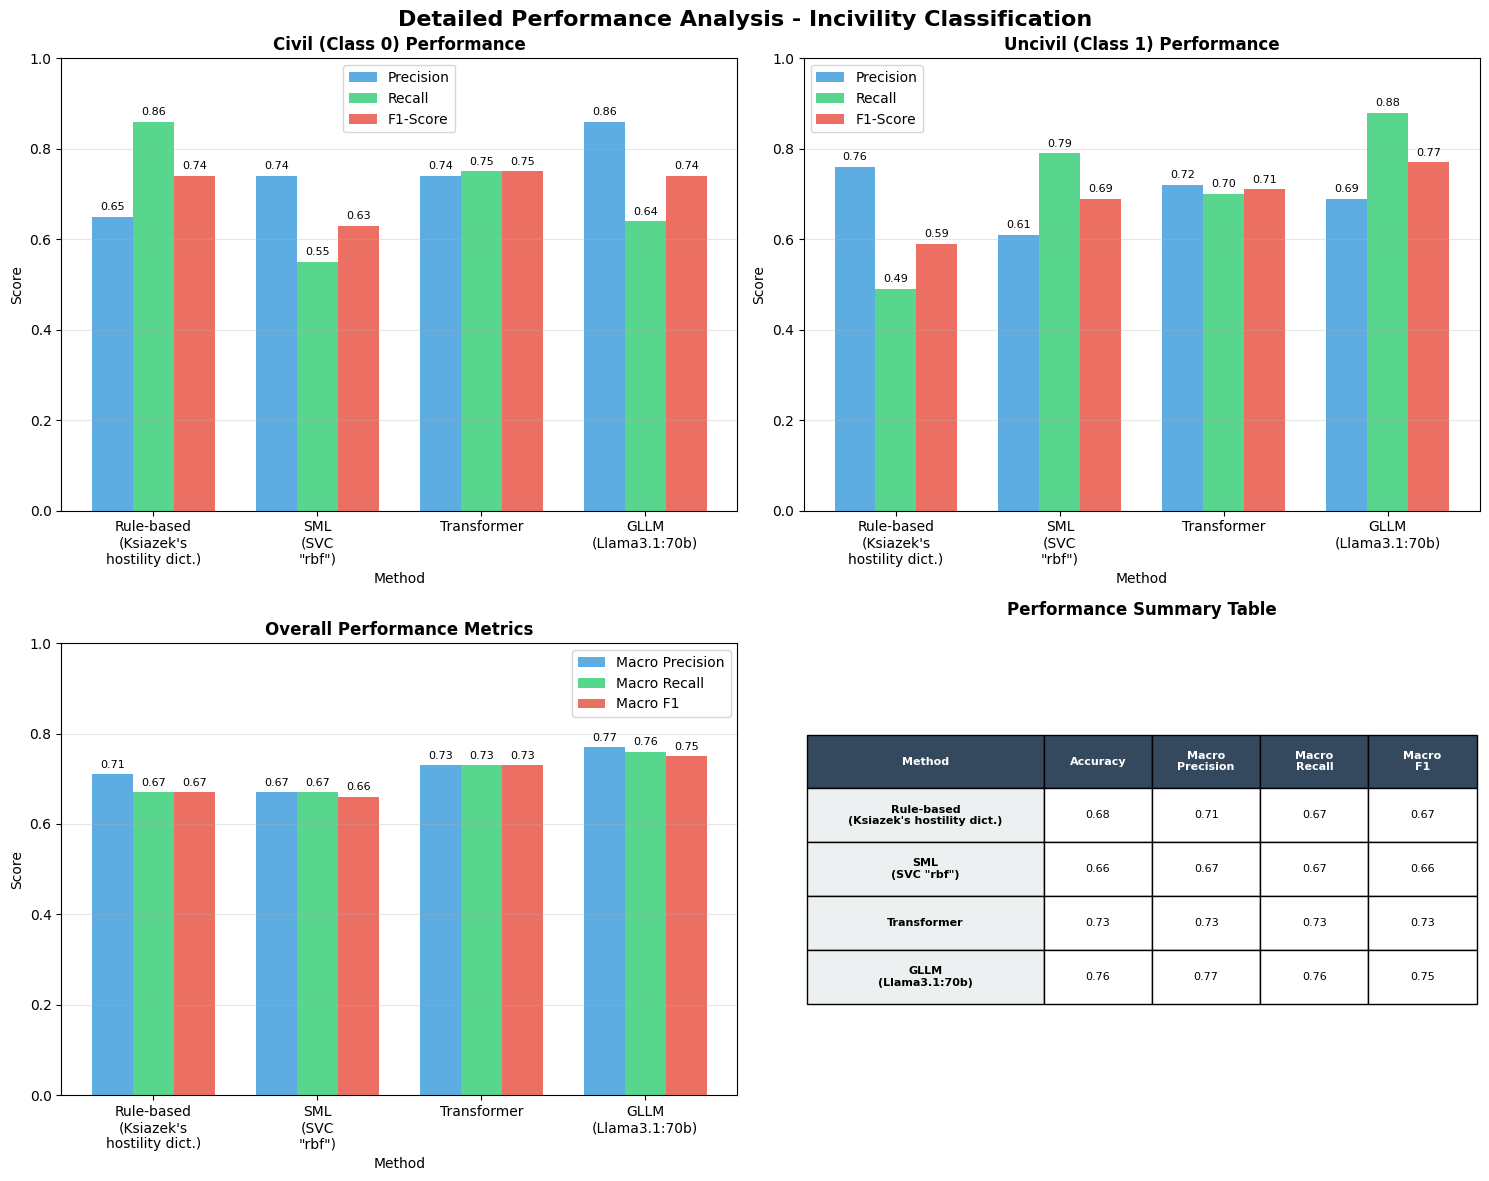


INCIVILITY CLASSIFICATION ANALYSIS INSIGHTS
• Best Macro F1: GLLM (Llama3.1:70b) (0.75)
• Best Accuracy: GLLM (Llama3.1:70b) (0.76)

• Class Balance Analysis:
  - Average Civil F1: 0.72
  - Average Uncivil F1: 0.69
  - Difference: 0.03 (Most balanced classification task)


In [55]:
# Visualization of Incivility Classification Performance Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract data from incivility_performance_table for visualization
incivility_methods = list(incivility_performance_table.keys())
incivility_macro_f1_values = [incivility_performance_table[method]['macro_average']['f1_score'] for method in incivility_methods]
incivility_accuracy_values = [incivility_performance_table[method]['accuracy'] for method in incivility_methods]
incivility_class0_f1_values = [incivility_performance_table[method]['class_0']['f1_score'] for method in incivility_methods]
incivility_class1_f1_values = [incivility_performance_table[method]['class_1']['f1_score'] for method in incivility_methods]

# Extract precision and recall for individual classes
incivility_class0_precision = [incivility_performance_table[method]['class_0']['precision'] for method in incivility_methods]
incivility_class0_recall = [incivility_performance_table[method]['class_0']['recall'] for method in incivility_methods]
incivility_class1_precision = [incivility_performance_table[method]['class_1']['precision'] for method in incivility_methods]
incivility_class1_recall = [incivility_performance_table[method]['class_1']['recall'] for method in incivility_methods]
incivility_macro_precision = [incivility_performance_table[method]['macro_average']['precision'] for method in incivility_methods]
incivility_macro_recall = [incivility_performance_table[method]['macro_average']['recall'] for method in incivility_methods]

# Create a comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed Performance Analysis - Incivility Classification', fontsize=16, fontweight='bold')

# Colors for consistency
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Get class labels from the first method
class0_label = incivility_performance_table[incivility_methods[0]]['class_0']['label']
class1_label = incivility_performance_table[incivility_methods[0]]['class_1']['label']

# 1. Class 0 Performance (precision, recall, F1)
x = np.arange(len(incivility_methods))
width = 0.25
bars1_1 = ax1.bar(x - width, incivility_class0_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars1_2 = ax1.bar(x, incivility_class0_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars1_3 = ax1.bar(x + width, incivility_class0_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax1.set_title(f'{class0_label} (Class 0) Performance', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Method')
ax1.set_xticks(x)
ax1.set_xticklabels([method.replace(' (', '\n(').replace('SVC "rbf"', 'SVC\n"rbf"').replace('Ksiazek\'s hostility dictionary', 'Ksiazek\'s\nhostility dict.') for method in incivility_methods], rotation=0, ha='center')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1_1, bars1_2, bars1_3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Class 1 Performance (precision, recall, F1)
bars2_1 = ax2.bar(x - width, incivility_class1_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars2_2 = ax2.bar(x, incivility_class1_recall, width, label='Recall', color='#2ecc71', alpha=0.8)
bars2_3 = ax2.bar(x + width, incivility_class1_f1_values, width, label='F1-Score', color='#e74c3c', alpha=0.8)
ax2.set_title(f'{class1_label} (Class 1) Performance', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xlabel('Method')
ax2.set_xticks(x)
ax2.set_xticklabels([method.replace(' (', '\n(').replace('SVC "rbf"', 'SVC\n"rbf"').replace('Ksiazek\'s hostility dictionary', 'Ksiazek\'s\nhostility dict.') for method in incivility_methods], rotation=0, ha='center')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars2_1, bars2_2, bars2_3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Overall Performance Metrics (without accuracy)
bars3_1 = ax3.bar(x - width, incivility_macro_precision, width, label='Macro Precision', color='#3498db', alpha=0.8)
bars3_2 = ax3.bar(x, incivility_macro_recall, width, label='Macro Recall', color='#2ecc71', alpha=0.8)
bars3_3 = ax3.bar(x + width, incivility_macro_f1_values, width, label='Macro F1', color='#e74c3c', alpha=0.8)
ax3.set_title('Overall Performance Metrics', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Method')
ax3.set_xticks(x)
ax3.set_xticklabels([method.replace(' (', '\n(').replace('SVC "rbf"', 'SVC\n"rbf"').replace('Ksiazek\'s hostility dictionary', 'Ksiazek\'s\nhostility dict.') for method in incivility_methods], rotation=0, ha='center')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars3_1, bars3_2, bars3_3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 4. Summary Table
ax4.axis('tight')
ax4.axis('off')
ax4.set_title('Performance Summary Table', fontweight='bold', pad=20)

# Create table data
table_data = []
for method in incivility_methods:
    method_display = method
    if 'Rule-based' in method:
        method_display = 'Rule-based\n(Ksiazek\'s hostility dict.)'
    elif 'SML' in method:
        method_display = 'SML\n(SVC "rbf")'
    elif 'GLLM' in method:
        method_display = 'GLLM\n(Llama3.1:70b)'
    
    table_data.append([
        method_display,
        f"{incivility_performance_table[method]['accuracy']:.2f}",
        f"{incivility_performance_table[method]['macro_average']['precision']:.2f}",
        f"{incivility_performance_table[method]['macro_average']['recall']:.2f}",
        f"{incivility_performance_table[method]['macro_average']['f1_score']:.2f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Method', 'Accuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.16, 0.16, 0.16, 0.16])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 3)

# Style the table
for i in range(len(incivility_methods) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white', wrap=True)
        else:
            if j == 0:  # Method name column
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold', wrap=True)
            else:
                cell.set_facecolor('#ffffff')

plt.tight_layout()
plt.show()

# Print summary insights
print("\n" + "="*60)
print("INCIVILITY CLASSIFICATION ANALYSIS INSIGHTS")
print("="*60)

best_macro_f1 = max(incivility_macro_f1_values)
best_macro_method = incivility_methods[incivility_macro_f1_values.index(best_macro_f1)]
print(f"• Best Macro F1: {best_macro_method} ({best_macro_f1:.2f})")

best_accuracy = max(incivility_accuracy_values)
best_acc_method = incivility_methods[incivility_accuracy_values.index(best_accuracy)]
print(f"• Best Accuracy: {best_acc_method} ({best_accuracy:.2f})")

print(f"\n• Class Balance Analysis:")
avg_class0_f1 = np.mean(incivility_class0_f1_values)
avg_class1_f1 = np.mean(incivility_class1_f1_values)
print(f"  - Average {class0_label} F1: {avg_class0_f1:.2f}")
print(f"  - Average {class1_label} F1: {avg_class1_f1:.2f}")
print(f"  - Difference: {abs(avg_class0_f1 - avg_class1_f1):.2f} (Most balanced classification task)")